In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [91]:
df = pd.read_csv(r"c:\Users\User\Desktop\iran internet data 1 jan-31j jan\ioda-iran-(islamic-republic-of)-26-01-01-00-00-normalized.csv")   # فایل CSV
print(df.head())               # نمایش چند ردیف اول
print(df.info())               # بررسی نوع داده‌ها و نال‌ها
print(df.describe())           # خلاصه آماری برای داده‌های عددی
print(df.isnull().sum())  # تعداد نال‌ها در هر ستون


            Time (UTC)  Google (Search)  Telescope (# Unique Source IPs)  \
0  2025-12-01 00:00:00        20.889866                        22.143438   
1  2025-12-01 00:30:00        17.410982                        22.003952   
2  2025-12-01 01:00:00        15.303415                        21.666860   
3  2025-12-01 01:30:00        14.166347                        21.817970   
4  2025-12-01 02:00:00        15.654925                        23.026851   

   BGP (#Visible /24s)  Active Probing (#/24s Up)  Mozilla (City Count)  
0            99.623013                  96.585250                  15.0  
1            99.619811                  96.251457                   NaN  
2            99.618211                  95.949454                  12.5  
3            99.619811                  95.846138                   NaN  
4            99.618211                  95.462011                  17.5  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 6 col

In [92]:


# 1. تبدیل تایم (خیلی مهم برای سری زمانی)
df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'])
df = df.sort_values('Time (UTC)')
# 2. برای BGP و Probing و Google: استفاده از درونیابی (به جای میانگین ساده)
cols_to_fix = ['BGP (#Visible /24s)', 'Google (Search)', 'Active Probing (#/24s Up)']
df[cols_to_fix] = df[cols_to_fix].interpolate(method='linear')
# 3. برای موزیلا: اگه اصرار داری صفر باشه
df['Mozilla (City Count)'] = df['Mozilla (City Count)'].ffill()
# 4. برای تلسکوپ: پیشنهاد من ffill هست که وضعیت آخرین لحظه رو حفظ کنه
df['Telescope (# Unique Source IPs)'] = df['Telescope (# Unique Source IPs)'].ffill()
# 5. تنظیم زمان به عنوان ایندکس (اختیاری ولی به شدت پیشنهاد میشه)
df.set_index('Time (UTC)', inplace=True)
# حالا می‌تونی چک کنی که نوع داده عوض شده یا نه
print(df.index.dtype)


datetime64[ns]


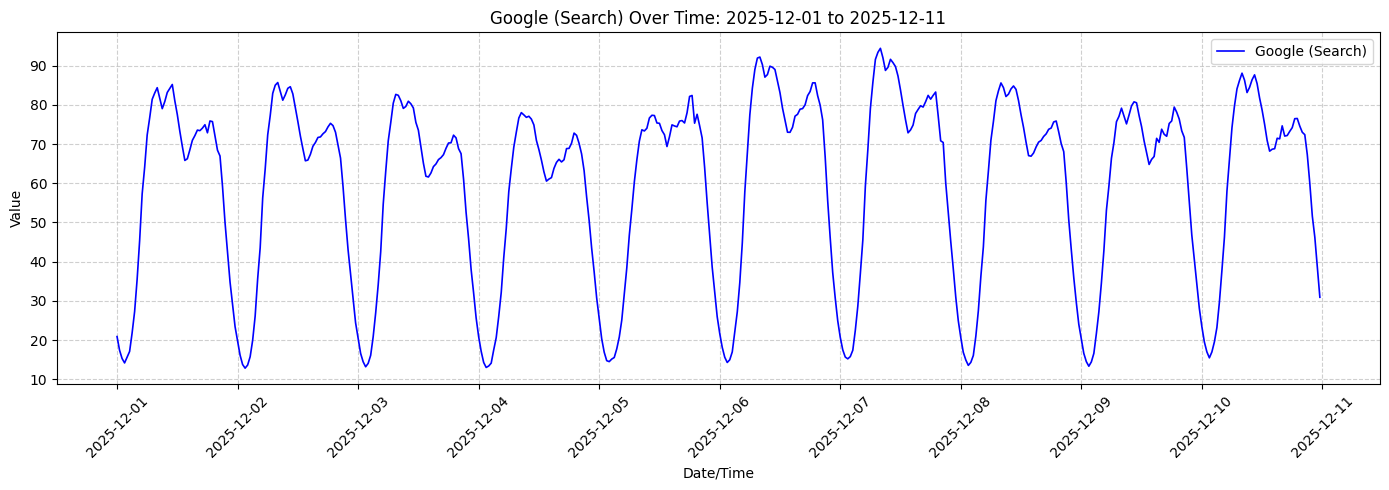

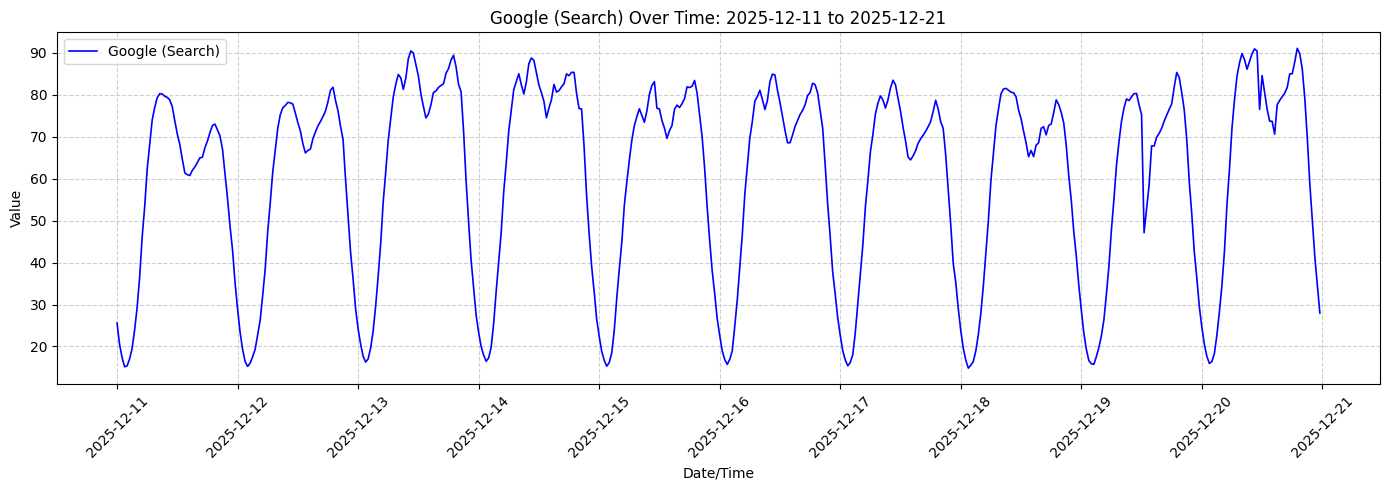

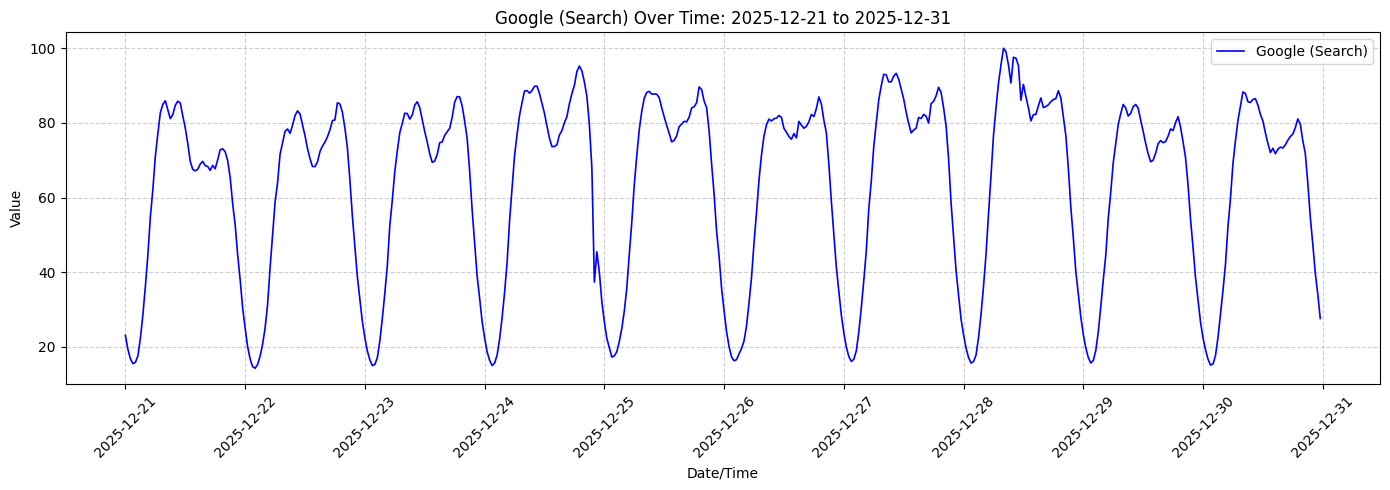

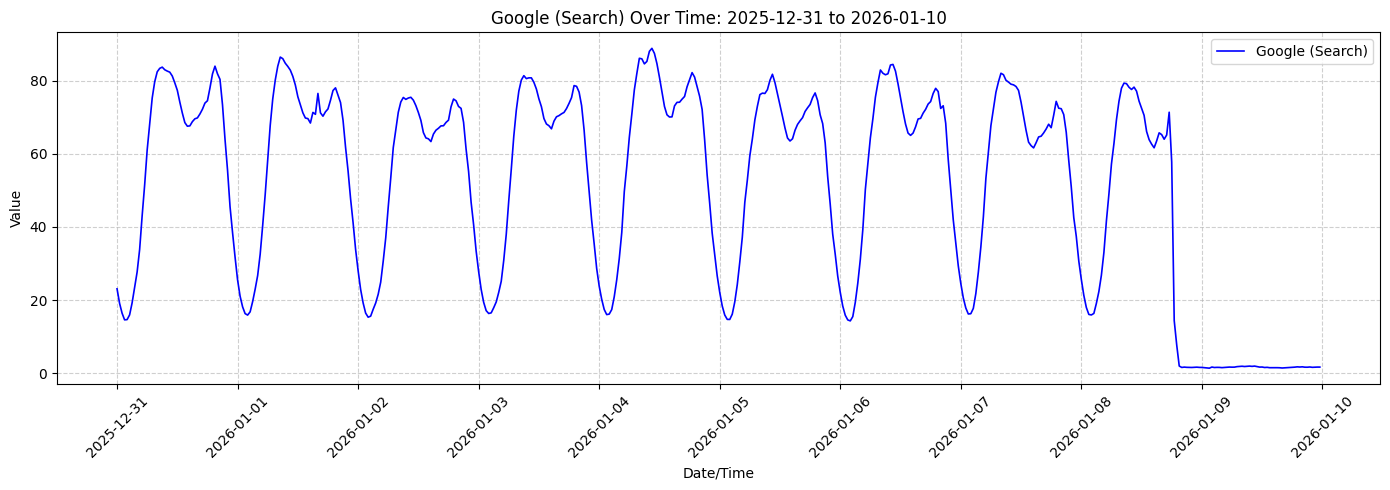

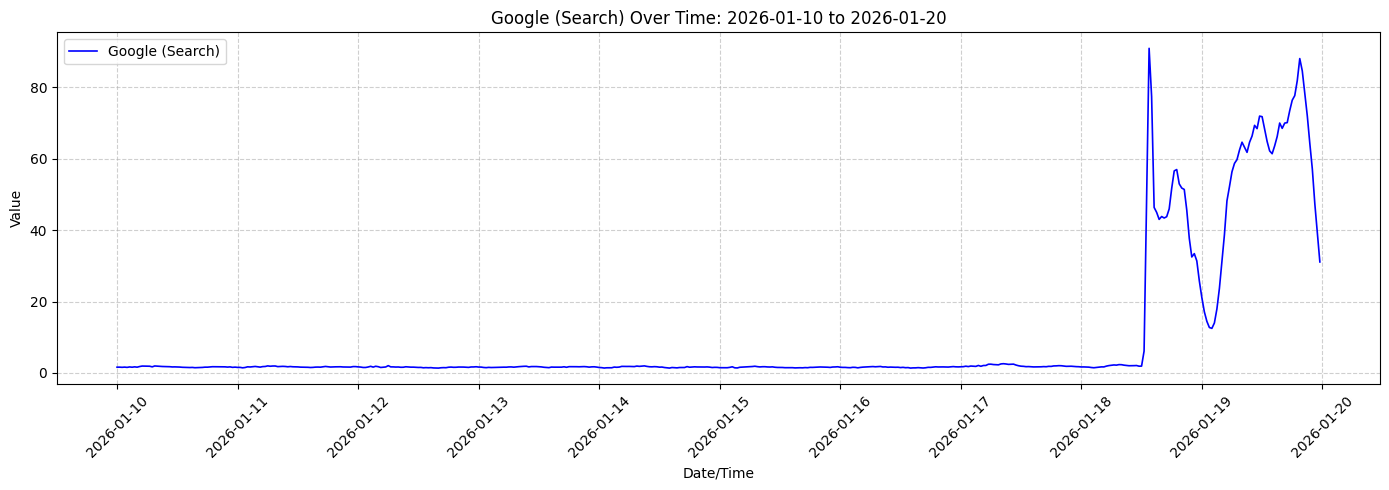

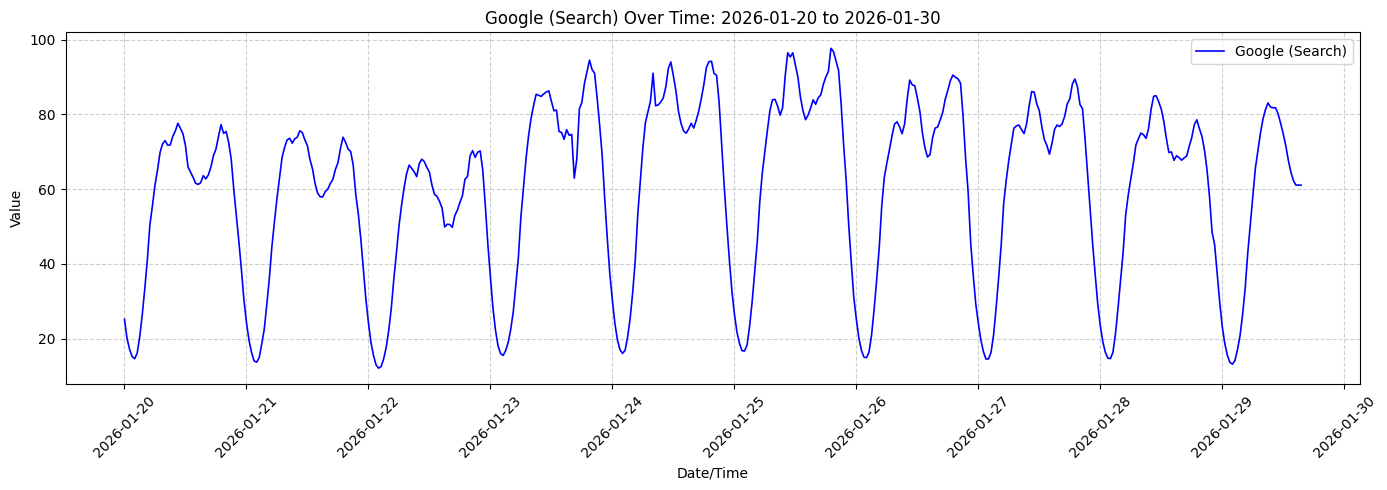

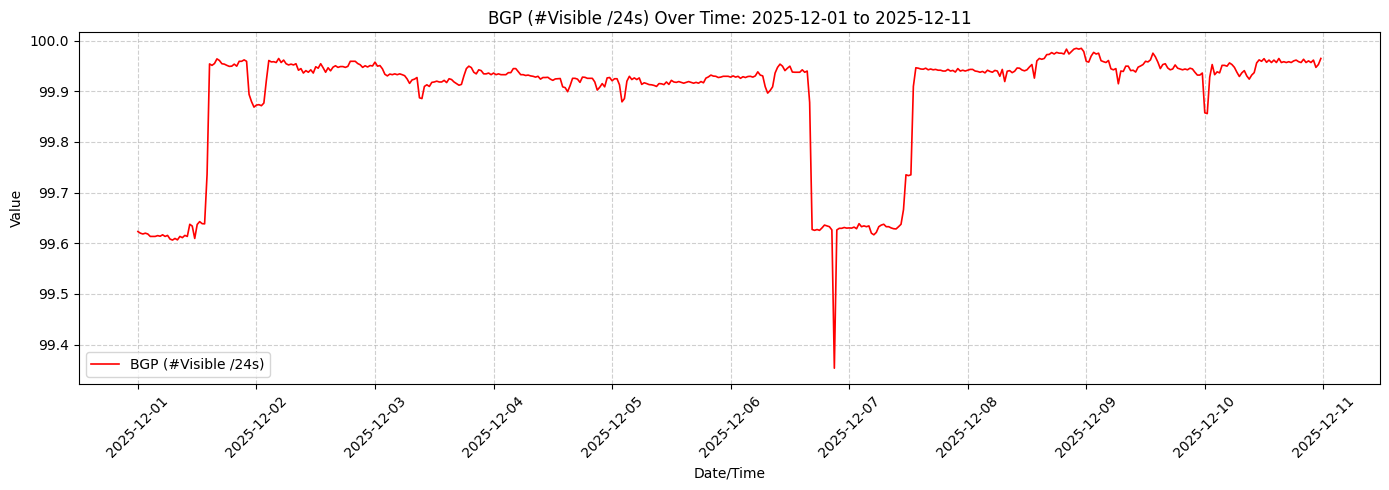

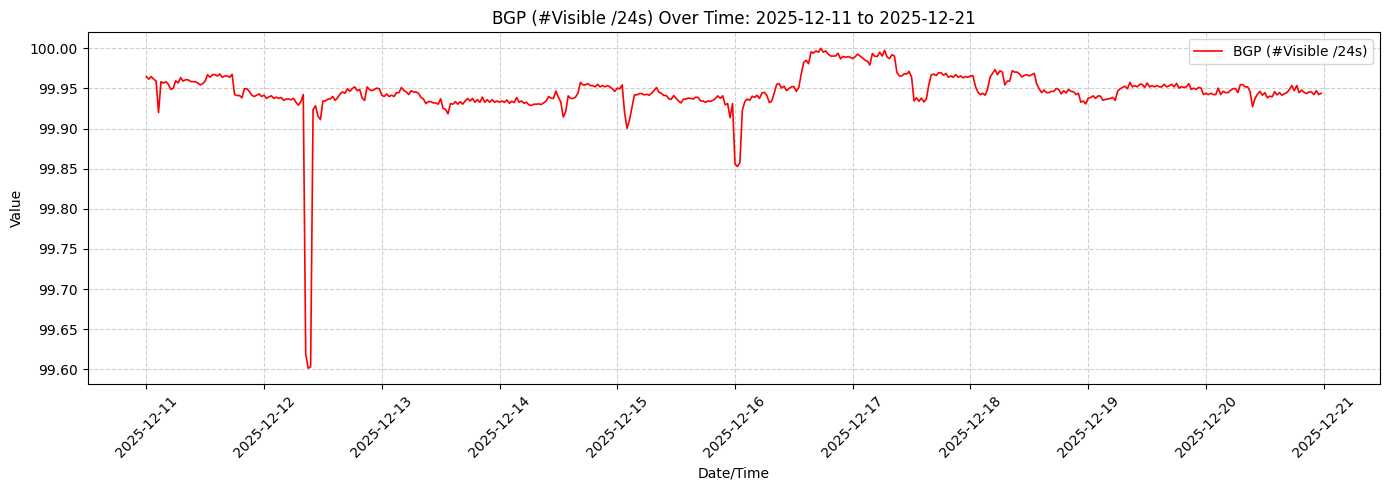

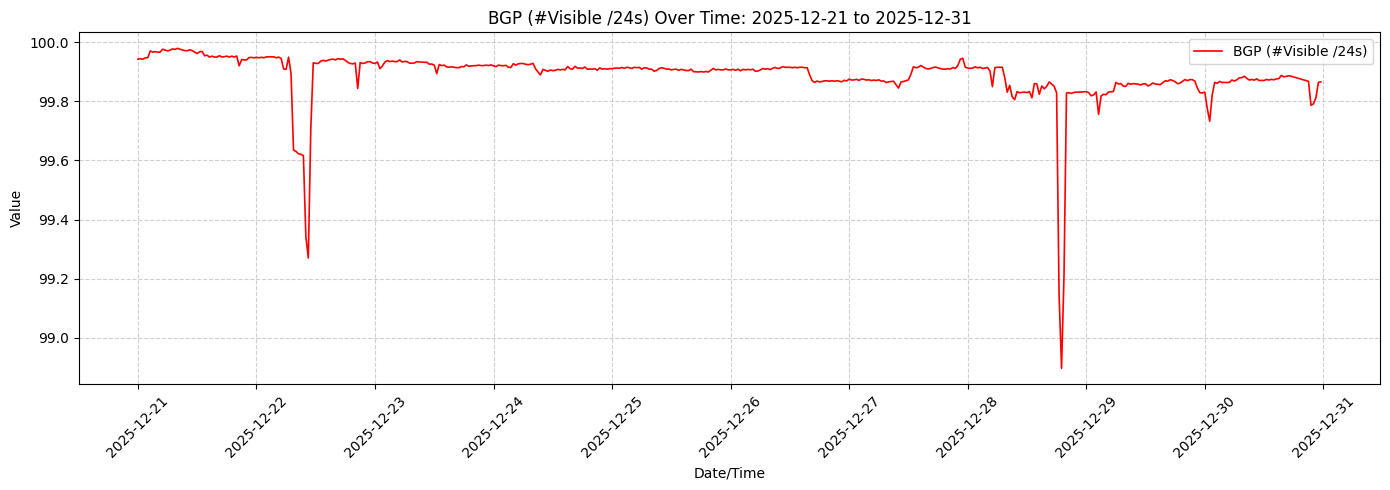

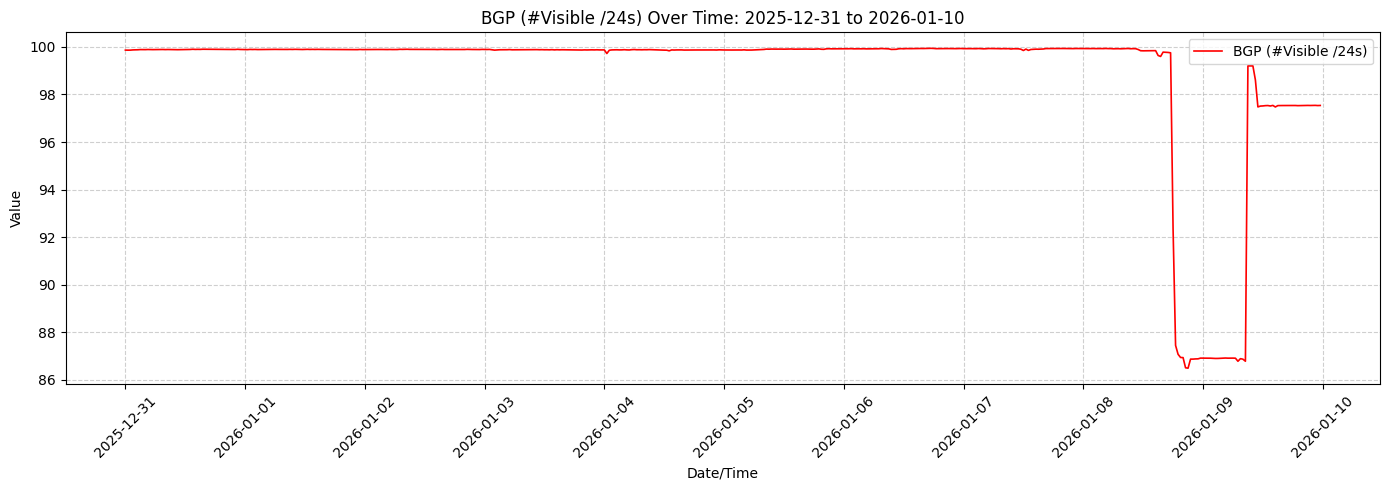

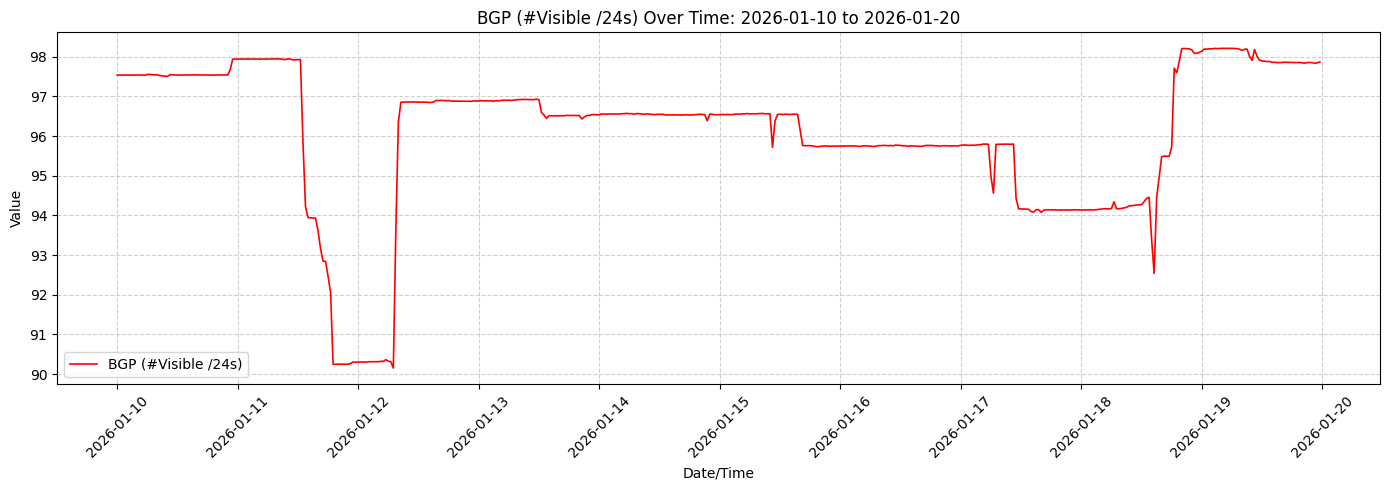

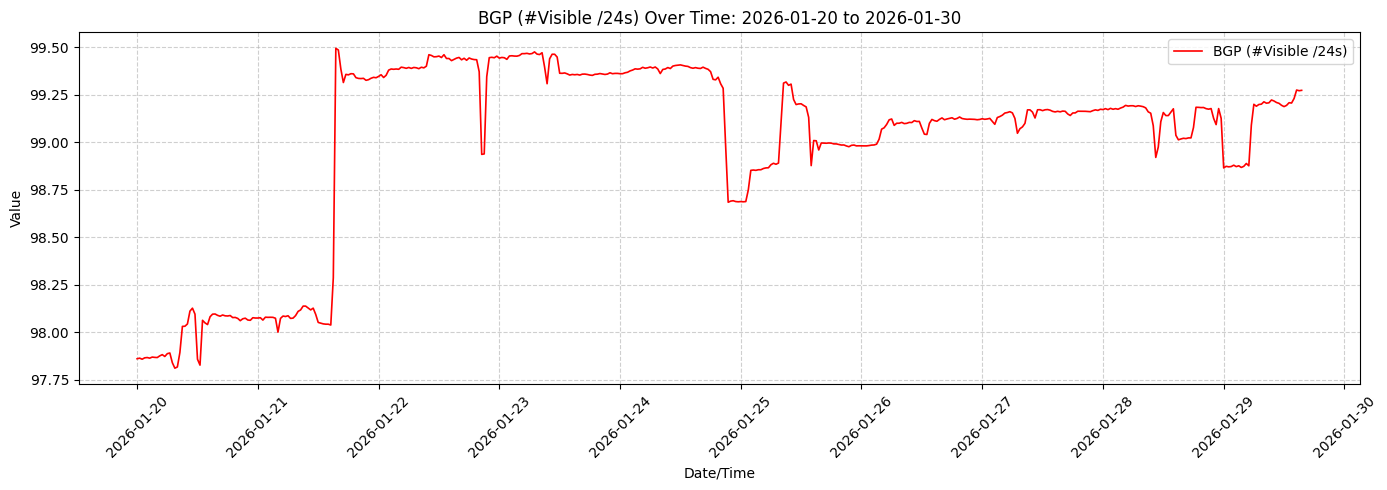

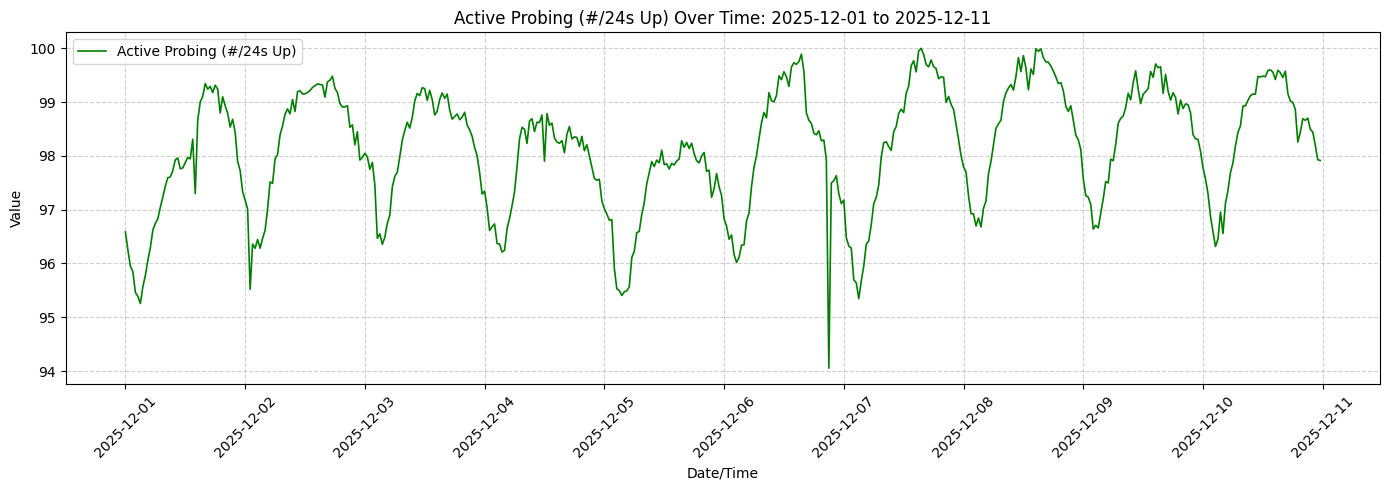

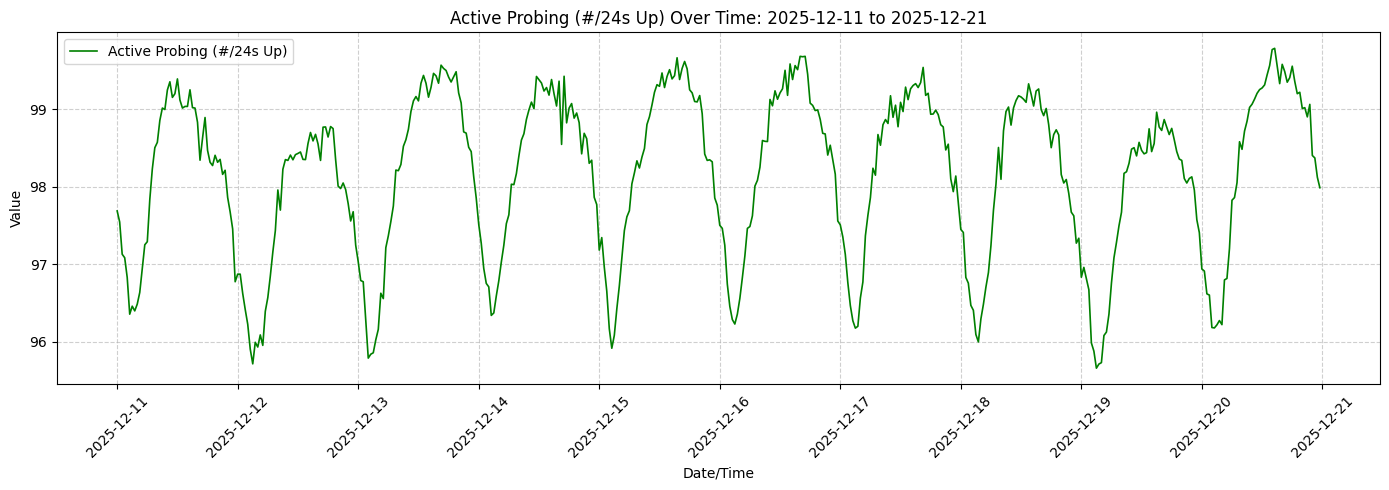

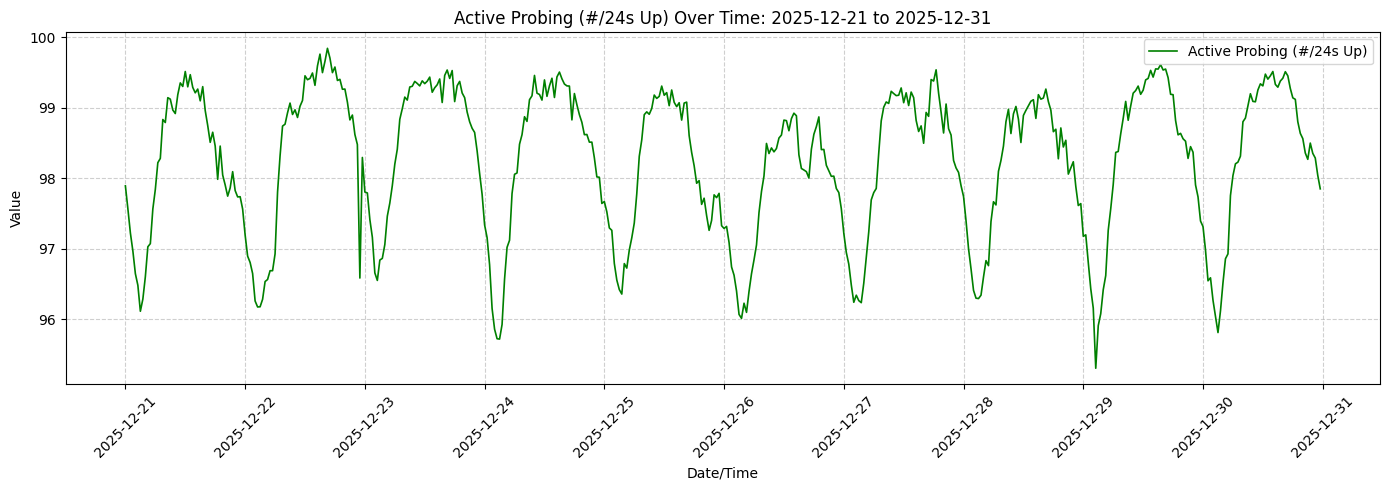

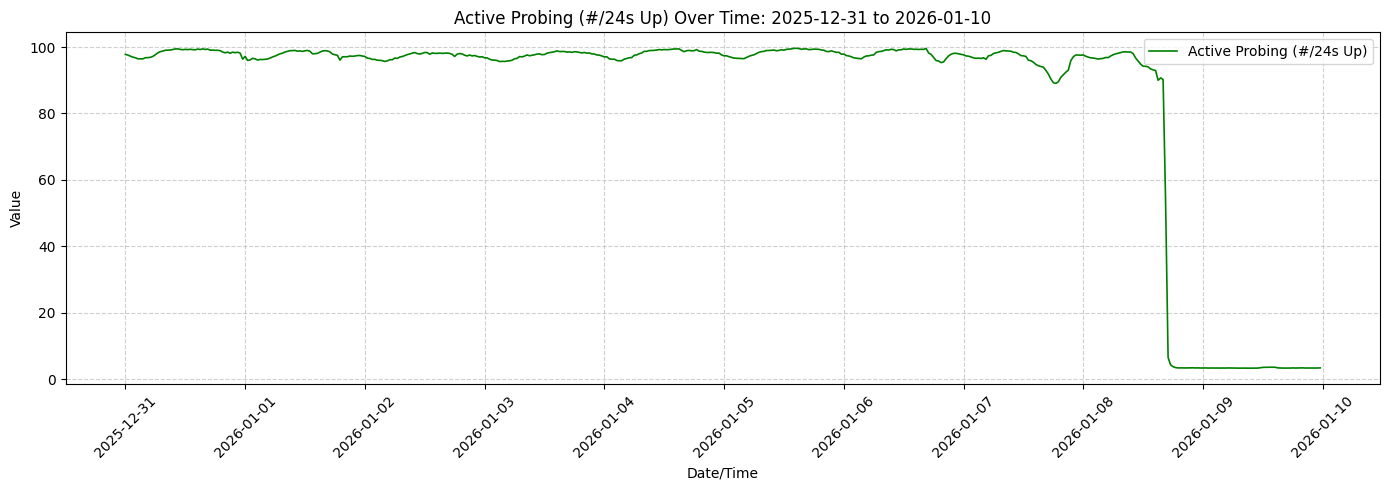

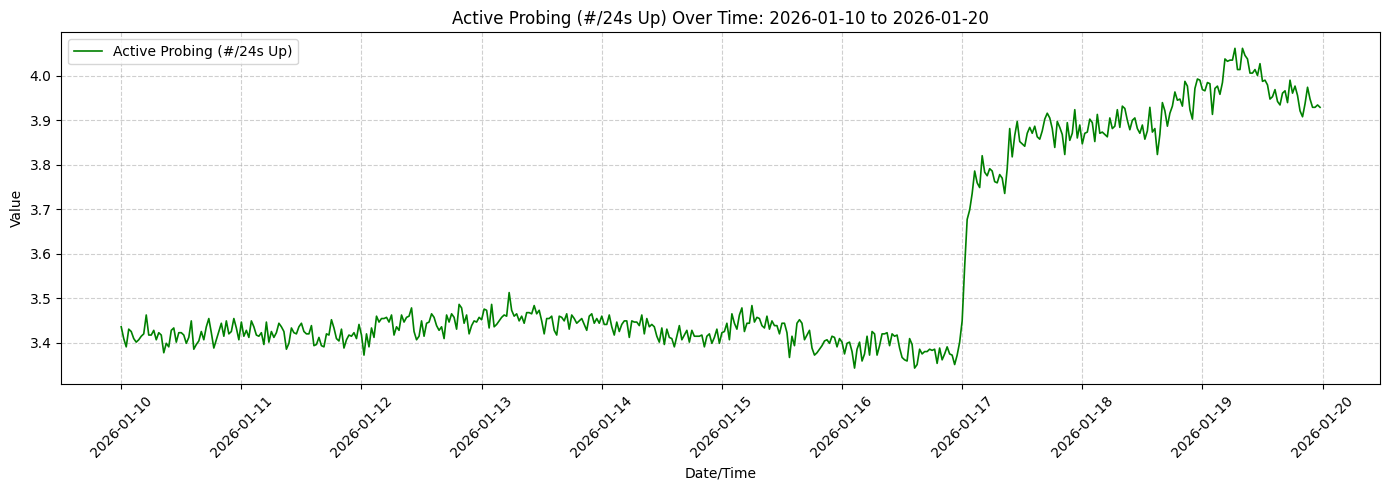

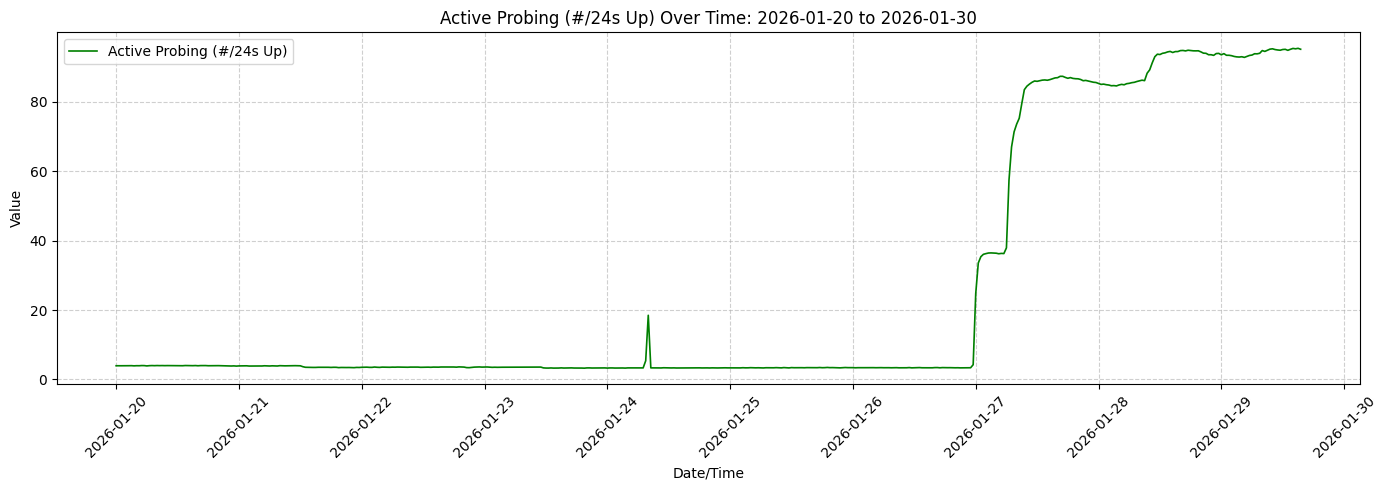

In [93]:

def plot_time_series_windows(data, column_name, days=10, color='blue'):
    """
    رسم نمودار برای یک ستون خاص در بازه‌های زمانی مشخص
    """
    if column_name not in data.columns:
        print(f"Error: Column '{column_name}' not found in DataFrame!")
        return

    start_date = data.index.min()
    end_date = data.index.max()
    current_start = start_date

    while current_start < end_date:
        current_end = current_start + pd.Timedelta(days=days)
        
        # جدا کردن بازه مورد نظر
        subset = data.loc[(data.index >= current_start) & (data.index < current_end)]
        
        if not subset.empty:
            plt.figure(figsize=(14, 5))
            plt.plot(subset.index, subset[column_name], label=column_name, color=color, linewidth=1.2)
            
            plt.title(f'{column_name} Over Time: {current_start.date()} to {current_end.date()}')
            plt.xlabel('Date/Time')
            plt.ylabel('Value')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        
        current_start = current_end
plot_time_series_windows(df, 'Google (Search)', days=10, color='blue')
plot_time_series_windows(df, 'BGP (#Visible /24s)', days=10, color='red')
plot_time_series_windows(df, 'Active Probing (#/24s Up)', days=10, color='green')

<div dir="rtl">

### 🔍 تحلیل فنی خروجی نمودارها

با بررسی همزمان این سه پارامتر در بازه‌های ۱۰ روزه، می‌توانیم به درک عمیقی از وضعیت زیرساخت و دسترسی کاربران برسیم:

1.  **Google Search (ترافیک لایه اپلیکیشن):** این نمودار نبضِ دسترسی کاربران عادی است. افت‌های شدید در این نمودار، در حالی که پارامترهای دیگر ثابت هستند، نشان‌دهنده اختلالات هدفمند (مانند فیلترینگ یا throttling) روی سرویس‌های خارجی است.
2.  **BGP Visibility (لایه زیرساخت جهانی):** این پارامتر پایداری مسیرهای شبکه در سطح جهانی را نشان می‌دهد. اگر در نمودار قرمز رنگ شاهد سقوط باشیم، یعنی بخشی از شبکه کلاً از نقشه اینترنت جهانی حذف شده است (Blackout).
3.  **Active Probing (پایداری گره‌ها):** این نمودار نشان می‌دهد که آیا آی‌پی‌های شبکه از نظر فنی فعال هستند یا خیر. 

#### 💡 تحلیل همبستگی (Correlation Analysis):
* **سناریوی اختلال سرویس:** اگر نمودار قرمز (BGP) و سبز (Probing) پایدار باشند اما نمودار آبی (Google) افت کند، یعنی اینترنت وصل است اما دسترسی به سرویس‌های خاص محدود شده.
* **سناریوی قطعی کلی:** افت همزمان هر سه نمودار نشان‌دهنده قطعی کامل فیزیکی یا اختلال در مرکز تبادل ترافیک (IXP) است.

</div>

<div dir="ltr">

### 🔍 Technical Analysis of Visualizations

By analyzing these three metrics in 10-day windows, we can distinguish between different types of network anomalies:

1.  **Google Search (Application Layer):** Represents the actual end-user experience. Sudden drops here—without a corresponding drop in infrastructure metrics—often indicate service-specific restrictions or throttling.
2.  **BGP Visibility (#Visible /24s):** Monitors the global routing table. A drop in the red plot signifies a BGP hijack or a complete withdrawal of IP prefixes from the global internet.
3.  **Active Probing (Infrastructure Health):** Measures the reachability of subnets. It tells us if the infrastructure is "alive" regardless of whether application traffic is allowed through.

#### 💡 Security Insight:
From an **AI Security** perspective, these plots serve as the ground truth for training anomaly detection models. A high "Gap" between Active Probing and Google Search is a primary indicator of non-technical interference (Censorship Detection).

</div>

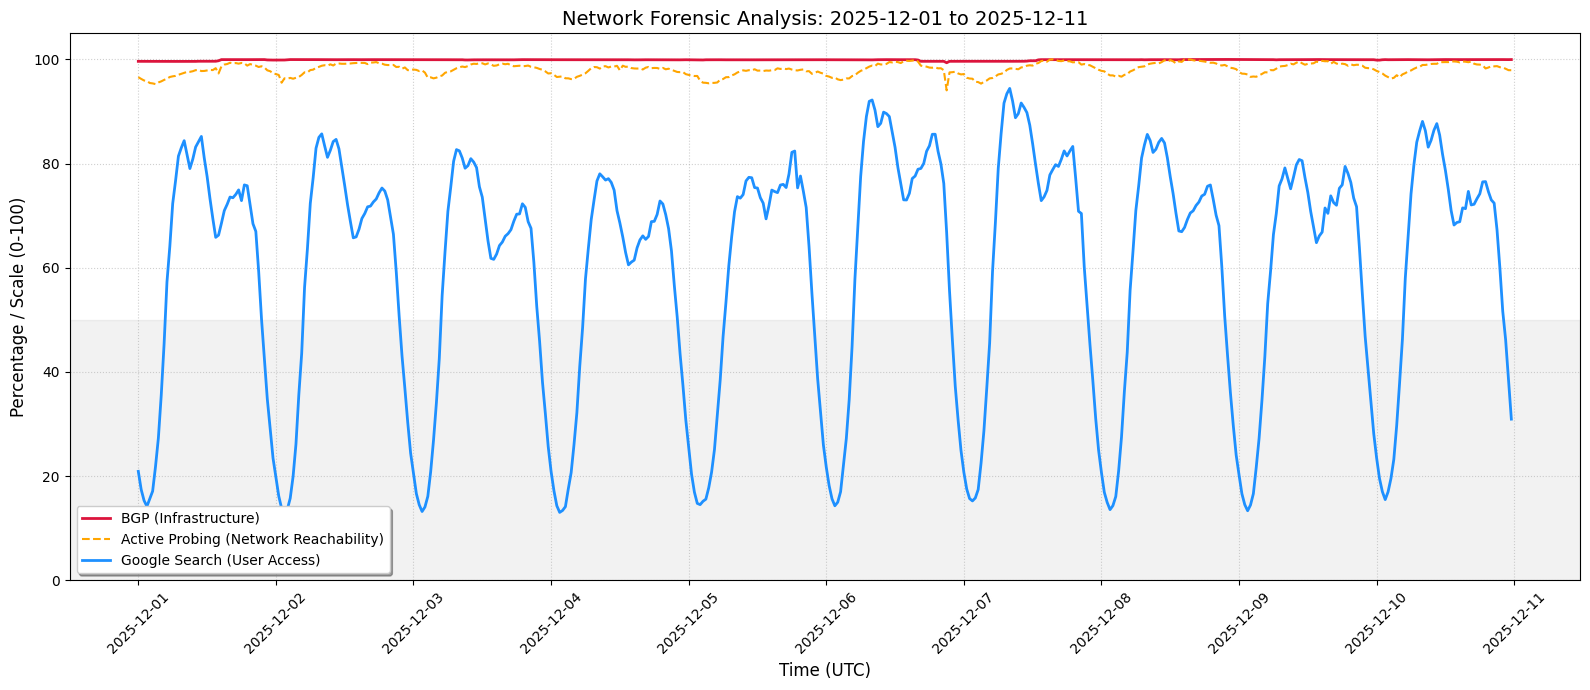

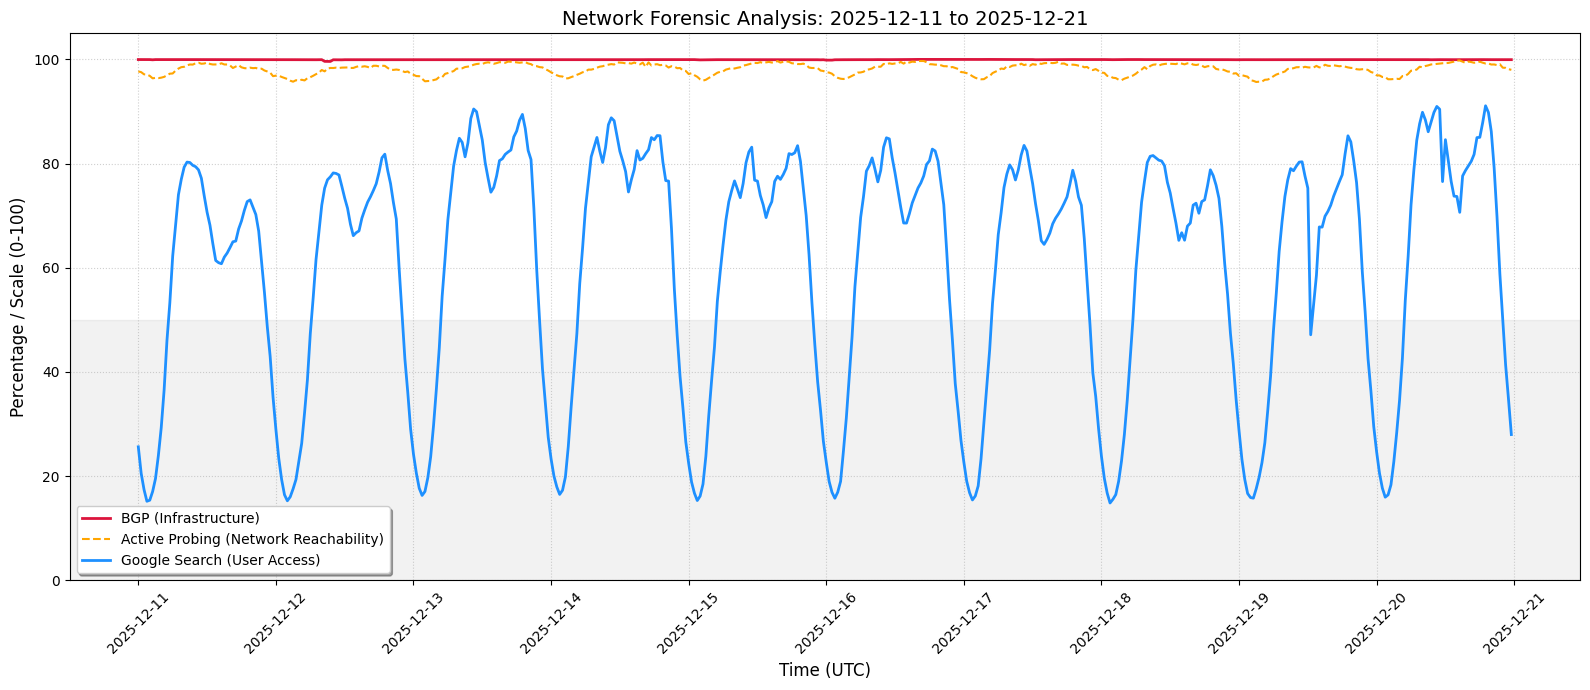

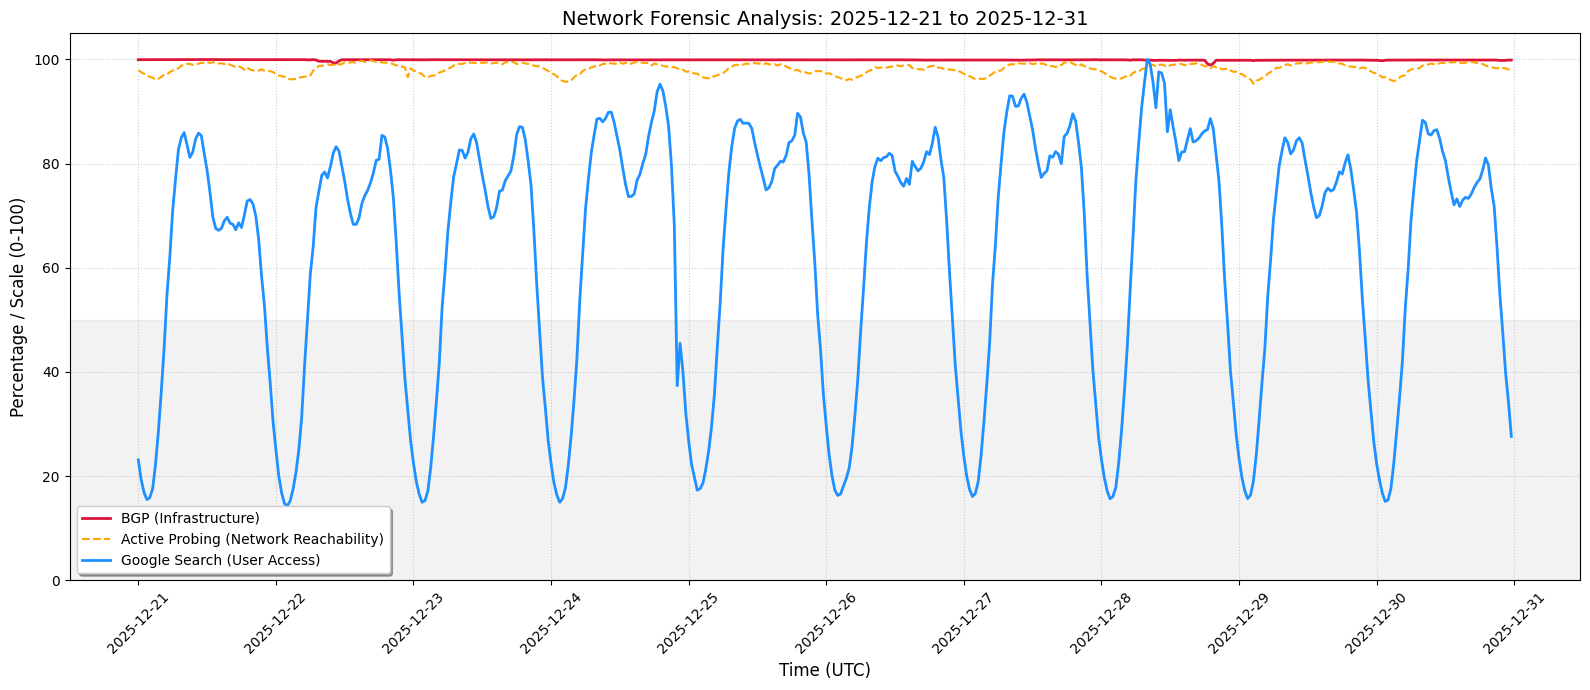

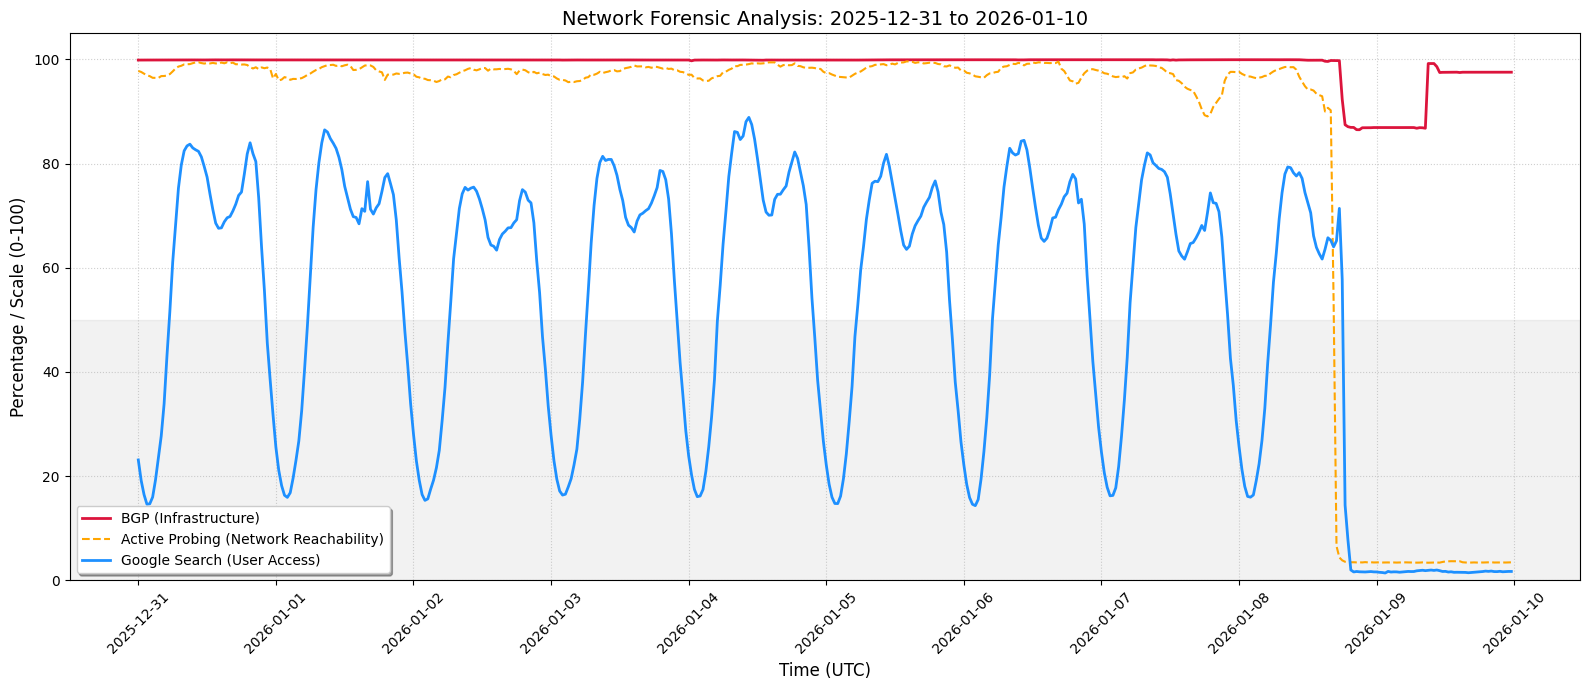

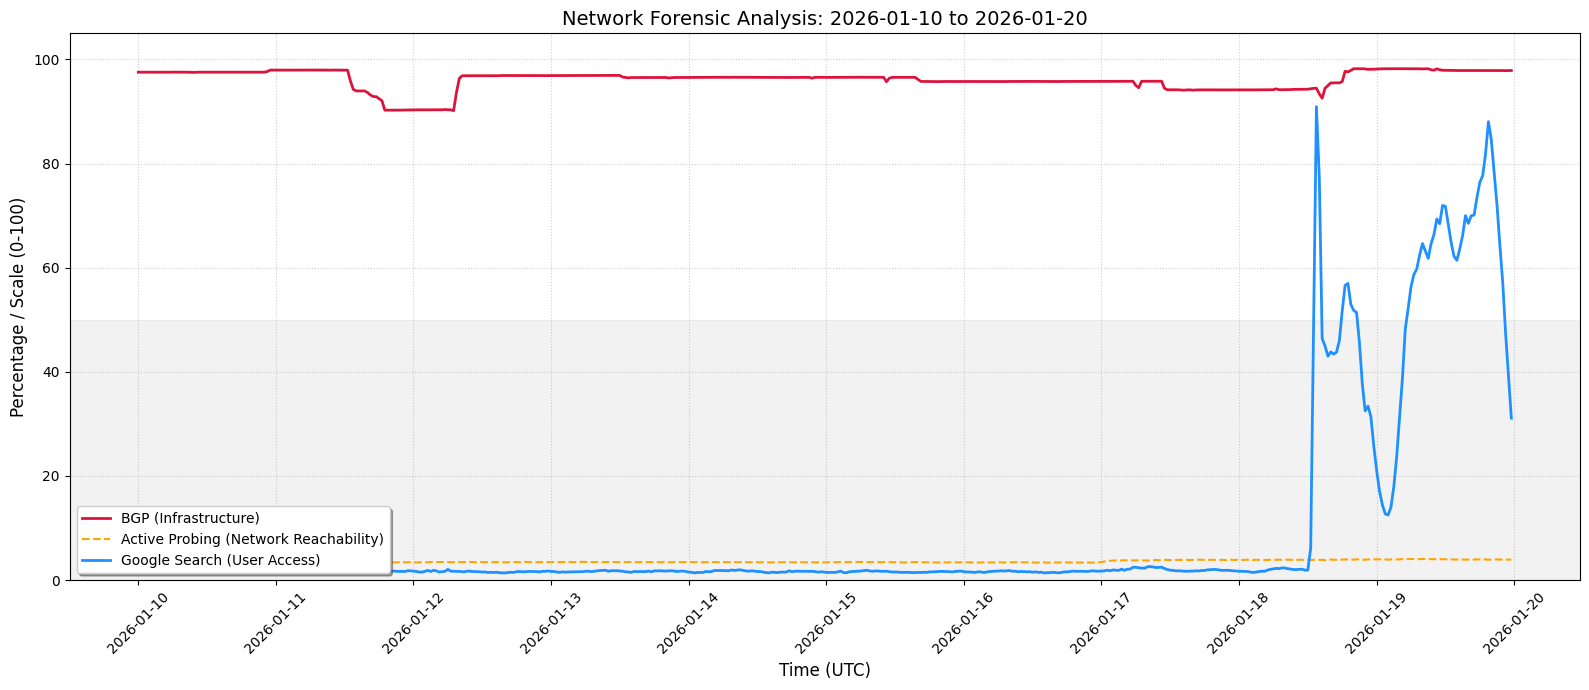

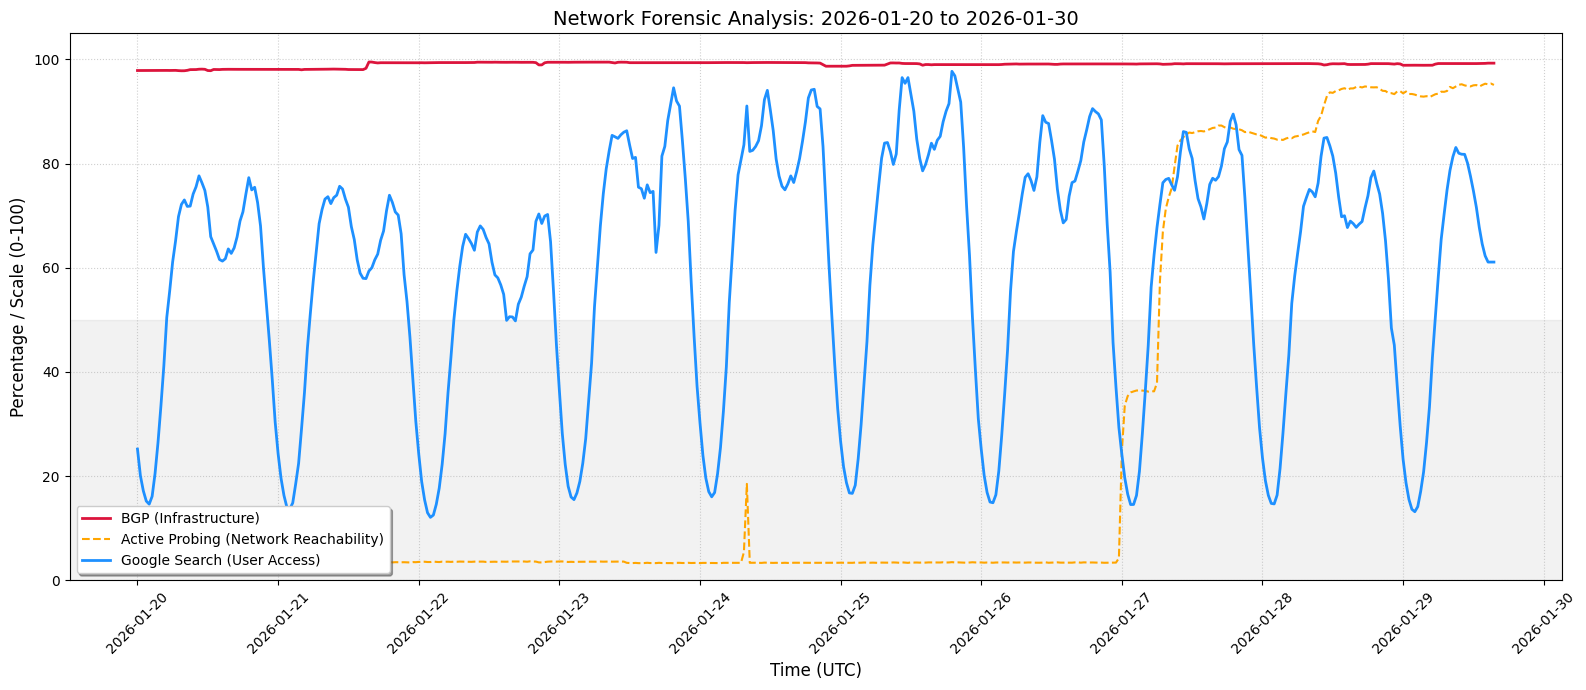

In [94]:

def plot_combined_forensics(data, days=10):
    """
    رسم سه شاخص اصلی در یک نمودار برای مقایسه فیلترینگ و قطعی
    """
    start_date = data.index.min()
    end_date = data.index.max()
    current_start = start_date

    while current_start < end_date:
        current_end = current_start + pd.Timedelta(days=days)
        subset = data.loc[(data.index >= current_start) & (data.index < current_end)]
        
        if not subset.empty:
            plt.figure(figsize=(16, 7))
            
            # رسم هر سه ستون
            plt.plot(subset.index, subset['BGP (#Visible /24s)'], 
                     label='BGP (Infrastructure)', color='crimson', linewidth=2)
            
            plt.plot(subset.index, subset['Active Probing (#/24s Up)'], 
                     label='Active Probing (Network Reachability)', color='orange', linewidth=1.5, linestyle='--')
            
            plt.plot(subset.index, subset['Google (Search)'], 
                     label='Google Search (User Access)', color='dodgerblue', linewidth=2)
            
            # تنظیمات محورها و مقیاس
            plt.ylim(0, 105)
            plt.title(f'Network Forensic Analysis: {current_start.date()} to {current_end.date()}', fontsize=14)
            plt.xlabel('Time (UTC)', fontsize=12)
            plt.ylabel('Percentage / Scale (0-100)', fontsize=12)
            
            # اضافه کردن جزئیات برای خوانایی بهتر
            plt.grid(True, which='both', linestyle=':', alpha=0.6)
            plt.legend(loc='lower left', frameon=True, shadow=True)
            plt.xticks(rotation=45)
            
            # هایلایت کردن ناحیه بحرانی (زیر ۵۰ درصد)
            plt.axhspan(0, 50, color='gray', alpha=0.1) 
            
            plt.tight_layout()
            plt.show()
        
        current_start = current_end


plot_combined_forensics(df)

<div dir="rtl">

### 🛡️ تحلیل جرم‌شناسی شبکه (Network Forensic Analysis)

در این سلول، با استفاده از تابع `plot_combined_forensics` هر سه لایه حیاتی اینترنت را در یک قاب مقایسه می‌کنیم. این نمودار ترکیبی، "امضای" (Signature) انواع اختلالات را به ما نشان می‌دهد.

#### 📊 اجزای نمودار و تفسیر فنی:

* **BGP (خط قرمز تیره):** نشان‌دهنده لایه ۳ (زیرساخت جهانی). اگر این خط افت کند، با یک **Blackout** یا قطعی فیزیکی/مسیریابی مواجه هستیم.
* **Active Probing (خط‌چین نارنجی):** نشان‌دهنده در دسترس بودن گره‌ها. این شاخص می‌گوید "آیا دستگاه‌ها روشن و متصل هستند؟" حتی اگر ترافیکی از آن‌ها عبور نکند.
* **Google Search (خط آبی):** شاخص لایه اپلیکیشن. نشان‌دهنده این است که "آیا کاربر نهایی واقعاً می‌تواند از سرویس استفاده کند؟"

#### 🧪 تشخیص نوع اختلال بر اساس الگو:

1.  **فیلترینگ/سانسور (Censorship):** خط آبی (Google) به شدت افت می‌کند، اما خط قرمز (BGP) و نارنجی (Probing) بالا می‌مانند. این یعنی راه باز است اما سرویس مسدود شده.
2.  **اختلال پهنای باند (Throttling):** خط آبی نوسانات شدید دارد و با فاصله زیادی زیرِ خط نارنجی قرار می‌گیرد.
3.  **قطعی سراسری (Total Shutdown):** هر سه نمودار با هم به زیر محدوده خاکستری (۵۰٪) سقوط می‌کنند.

> **نکته:** ناحیه خاکستری در پایین نمودار، "محدوده بحرانی" است که هرگونه حضور شاخص‌ها در این ناحیه، نشان‌دهنده یک اختلال سطح بالا در شبکه است.

</div>

<div dir="ltr">

### 🛡️ Network Forensic Analysis (Correlation Study)

The `plot_combined_forensics` function integrates three distinct network layers into a single visualization to identify the root cause of connectivity issues.

#### 📊 Metrics Breakdown:

* **BGP (Crimson Line):** Represents Layer 3 routing stability. A dip here indicates a structural blackout or routing withdrawal.
* **Active Probing (Orange Dashed):** Measures infrastructure reachability. It confirms if the network nodes are technically "alive."
* **Google Search (Dodger Blue):** Represents the Application Layer. This is the most sensitive metric for detecting user-side service availability.

#### 🔍 Forensic Pattern Recognition:

* **Targeted Blocking:** If the **Blue line** drops while **Crimson and Orange** remain stable, it confirms application-level censorship.
* **Infrastructure Failure:** A simultaneous drop in all three metrics indicates a physical link failure or a coordinated regional shutdown.
* **The "Censorship Gap":** The vertical distance between the Orange line (Infrastructure) and the Blue line (User Access) quantifies the severity of filtering.

*Note: The gray shaded area (0-50%) highlights critical instability zones.*

</div>

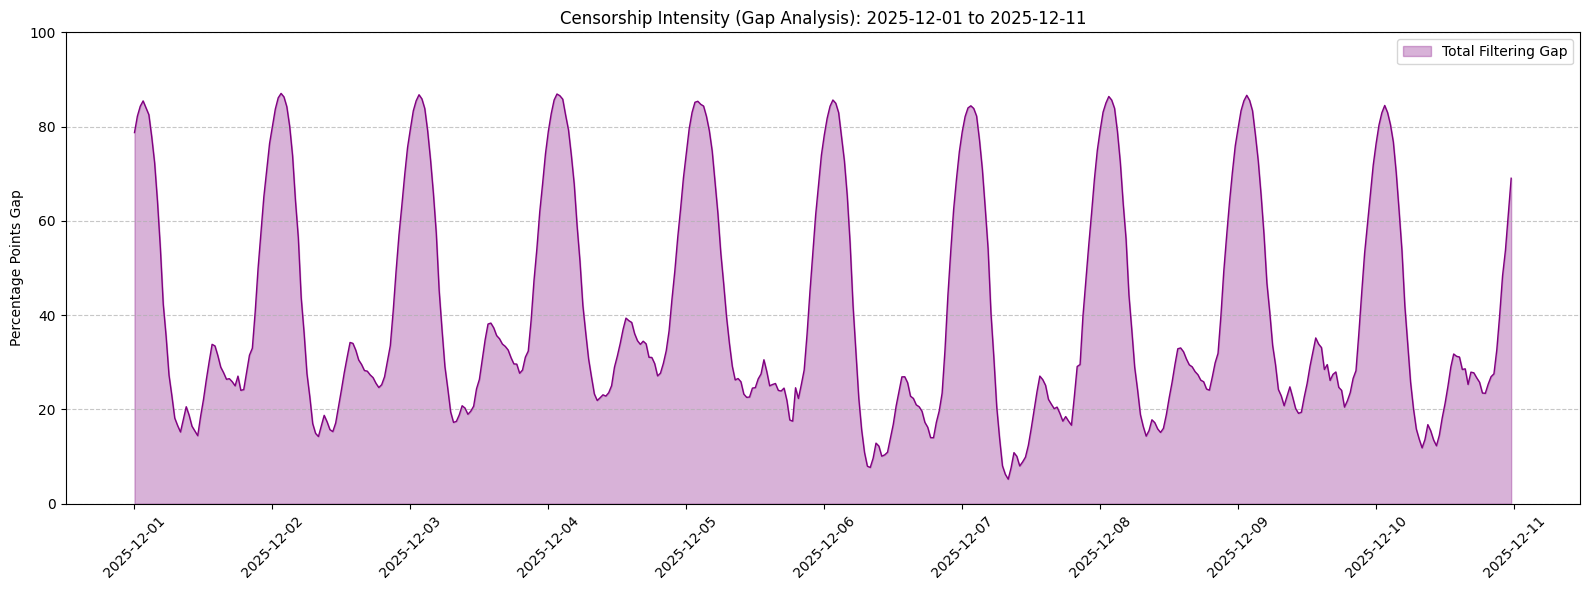

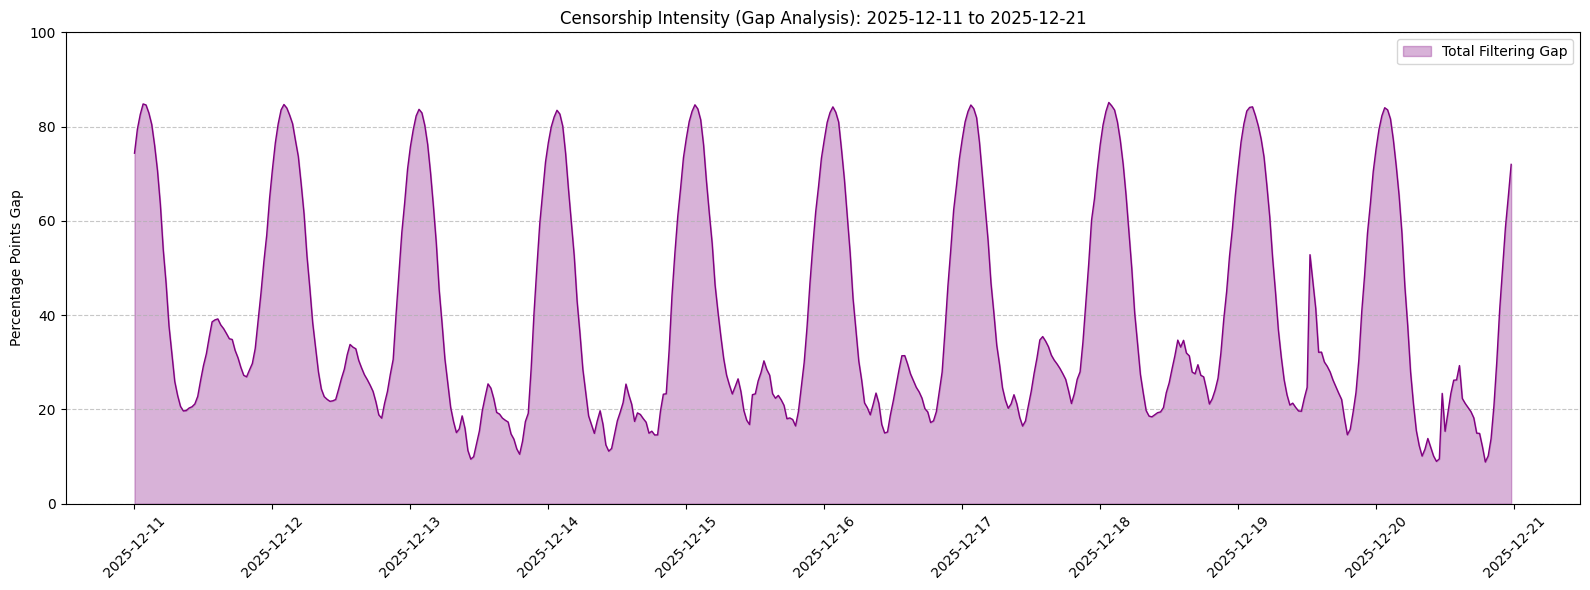

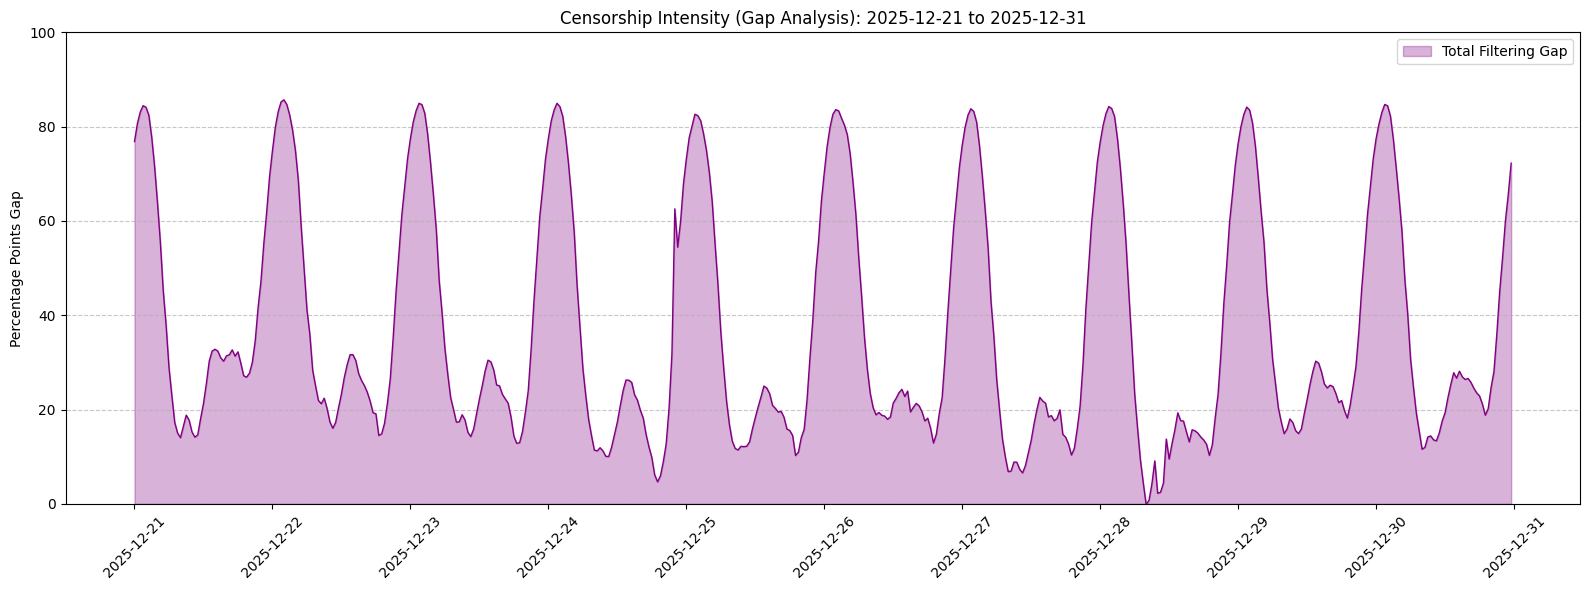

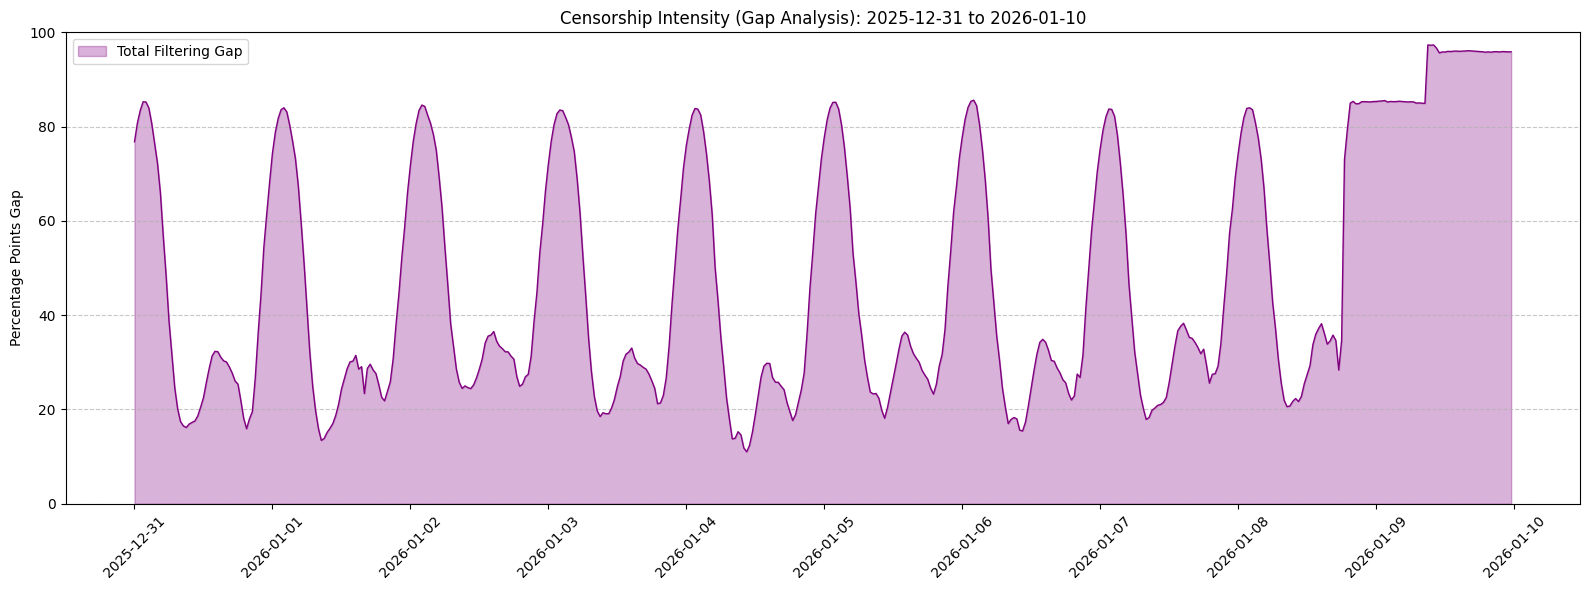

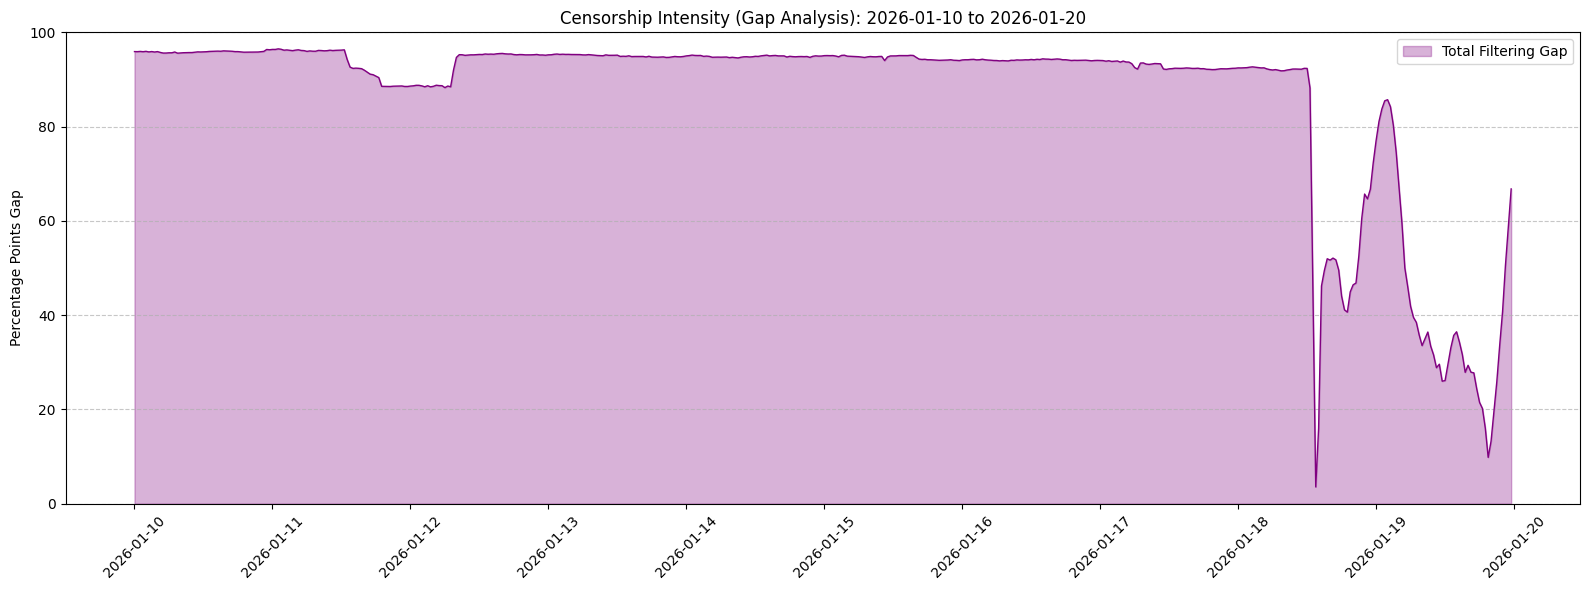

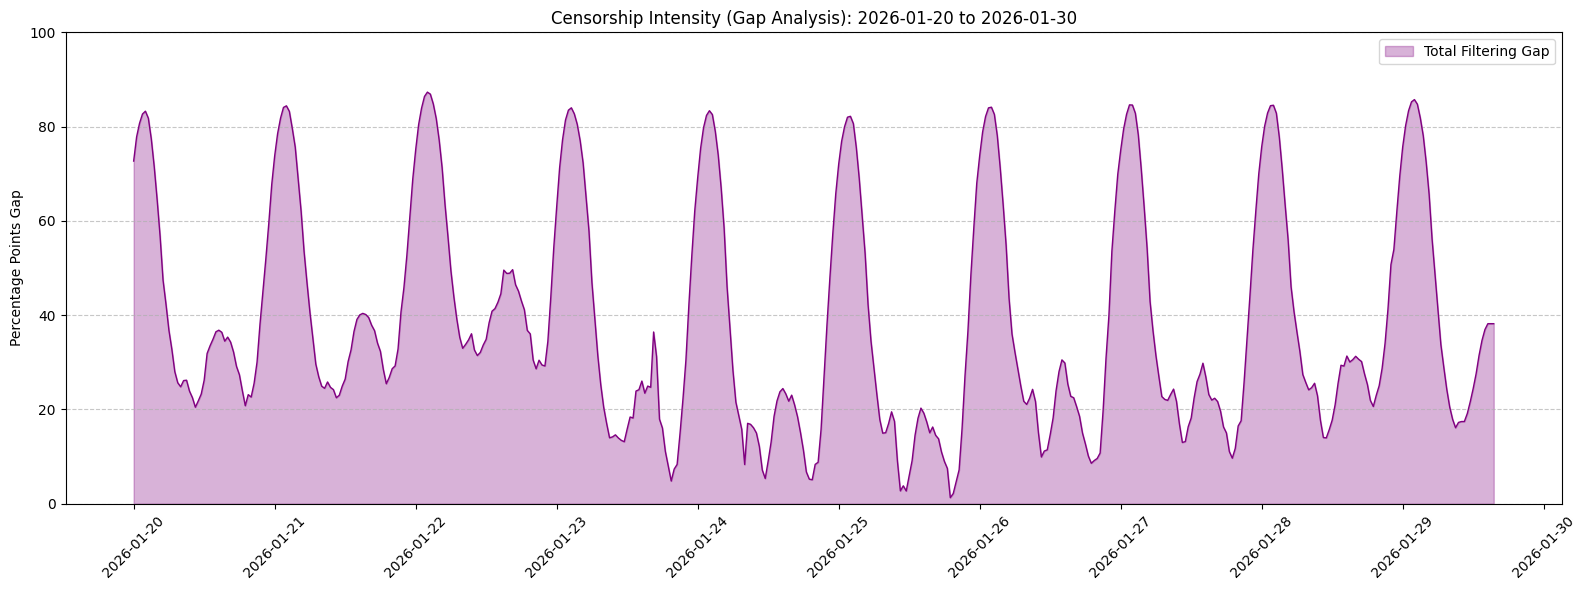

In [95]:
# ۱. محاسبه تفاضل‌ها
# هر چی این عدد بزرگتر باشه، یعنی فیلترینگ یا اختلال لایه اپلیکیشن شدیدتره
df['Filtering_Gap'] = df['BGP (#Visible /24s)'] - df['Google (Search)']

# اختلاف بین پایداری شبکه و دسترسی واقعی
df['Reachability_Gap'] = df['Active Probing (#/24s Up)'] - df['Google (Search)']

# ۲. تابع برای رسم این اختلافات
def plot_gaps(data, days=10):
    start_date = data.index.min()
    end_date = data.index.max()
    current_start = start_date

    while current_start < end_date:
        current_end = current_start + pd.Timedelta(days=days)
        subset = data.loc[(data.index >= current_start) & (data.index < current_end)]
        
        if not subset.empty:
            plt.figure(figsize=(16, 6))
            
            # رسم شکاف فیلترینگ
            plt.fill_between(subset.index, subset['Filtering_Gap'], color="purple", alpha=0.3, label='Total Filtering Gap')
            plt.plot(subset.index, subset['Filtering_Gap'], color="purple", linewidth=1)
            
            plt.title(f'Censorship Intensity (Gap Analysis): {current_start.date()} to {current_end.date()}')
            plt.ylabel('Percentage Points Gap')
            plt.ylim(0, 100) # چون اختلاف نمی‌تونه بیش از ۱۰۰ باشه
            plt.grid(True, axis='y', linestyle='--', alpha=0.7)
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
        current_start = current_end

# اجرا برای دیدن شدت اختلال
plot_gaps(df)

<div dir="rtl">

### ⚖️ تحلیل شکاف دسترسی (Gap Analysis) و شاخص شدت فیلترینگ

در این بخش، ما از یک رویکرد مهندسی ویژگی (Feature Engineering) برای اندازه‌گیری دقیق‌تر اختلالات استفاده می‌کنیم. به جای نگاه کردن به نمودارها به صورت جداگانه، **تفاضل** آن‌ها را محاسبه می‌کنیم.

#### 🧮 شاخص‌های تعریف شده:
* **Filtering Gap:** تفاضل بین پایداری زیرساخت (BGP) و دسترسی کاربر (Google). هرچه این عدد بزرگتر باشد، نشان‌دهنده فیلترینگ شدیدتر در لایه‌های بالای شبکه است.
* **Reachability Gap:** تفاوت بین زنده بودن شبکه (Active Probing) و امکان استفاده از سرویس.

#### 📈 تفسیر نمودار بنفش (Censorship Intensity):
این نمودار "خالصِ اختلال" را نشان می‌دهد. 
* **قله‌ها (Peaks):** زمان‌هایی که اینترنت از نظر فنی "وصل" بوده اما دسترسی به شدت محدود شده است.
* **ثبات در سطح بالا:** نشان‌دهنده فیلترینگ سیستماتیک و پایدار.
* **کف‌ها (Valleys):** زمان‌هایی که سطح دسترسی کاربر به پایداری زیرساخت نزدیک شده است.

</div>

<div dir="ltr">

### ⚖️ Gap Analysis: Measuring Censorship Intensity

In this step, we apply **Feature Engineering** to quantify the severity of network interference. By calculating the delta between infrastructure stability and actual service availability, we create a specialized metric for "Censorship Intensity."

#### 🧮 Defined Metrics:
* **Filtering Gap:** The mathematical difference between BGP visibility and Google Search traffic. A higher gap indicates that while the infrastructure is present, the application layer is being heavily restricted.
* **Reachability Gap:** Highlights the discrepancy between technical network "up-time" and meaningful user access.

#### 🔍 What the Purple Plot Tells Us:
Instead of looking at raw traffic, we are now looking at **The Loss**. 
* **High Values:** Indicate "Soft Shutdowns" or heavy censoring where the network is technically alive but practically unusable.
* **Low Values:** Indicate a transparent network state where user access aligns with infrastructure health.

This "Gap" is the perfect input feature for an **ML Anomaly Detection** model to automatically flag non-technical network interference.

</div>

In [96]:
# ۱. جدا کردن بازه بحرانی که پیدا کردی
critical_period = df.loc['2026-1-10':'2026-1-18']

# ۲. بررسی میانگین بقیه ستون‌ها در این بازه
# این بهت می‌گه کدوم سرویس‌ها با وجود قطع بودن گوگل، هنوز بالا بودن
print("Average traffic during total blackout (jan(2026) 10-18):")
print(critical_period[['Telescope (# Unique Source IPs)', 'Active Probing (#/24s Up)', 'Mozilla (City Count)']].mean())

Average traffic during total blackout (jan(2026) 10-18):
Telescope (# Unique Source IPs)    0.087238
Active Probing (#/24s Up)          3.521820
Mozilla (City Count)               1.736111
dtype: float64


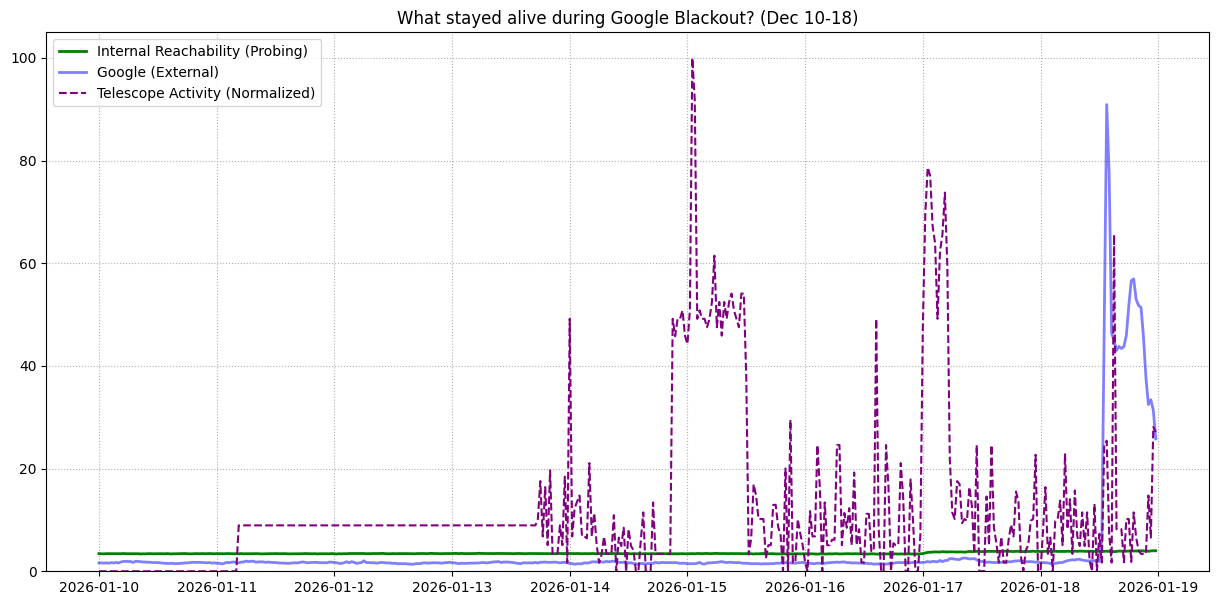

ثبات دسترسی در زمان قطعی: 94.68%


In [97]:
def plot_critical_zone(data):
    # زوم روی بازه ۱۰ تا ۱۸ دسامبر
    subset = data.loc['2026-1-10':'2026-1-18']
    
    if not subset.empty:
        plt.figure(figsize=(15, 7))
        
        # رسم ستون‌هایی که احتمالا زنده بودن
        plt.plot(subset.index, subset['Active Probing (#/24s Up)'], label='Internal Reachability (Probing)', color='green', linewidth=2)
        plt.plot(subset.index, subset['Google (Search)'], label='Google (External)', color='blue', linewidth=2, alpha=0.5)
        
        # اگه تلسکوپ رو نرمالایز کنی (مثلا تقسیم بر ماکزیممش کنی) می‌تونی کنار بقیه ببینی
        if subset['Telescope (# Unique Source IPs)'].max() > 0:
            telescope_norm = (subset['Telescope (# Unique Source IPs)'] / subset['Telescope (# Unique Source IPs)'].max()) * 100
            plt.plot(subset.index, telescope_norm, label='Telescope Activity (Normalized)', color='purple', linestyle='--')

        plt.title('What stayed alive during Google Blackout? (Dec 10-18)')
        plt.ylim(0, 105)
        plt.grid(True, linestyle=':')
        plt.legend()
        plt.show()

plot_critical_zone(df)
# بررسی میزان نوسان در بازه بلک‌اوت
blackout_zone = df.loc['2026-01-10':'2026-01-18']

# اگه انحراف معیار نسبت به میانگین خیلی کم باشه، یعنی لیست سفید فیکس شده داریم
cv = blackout_zone['Active Probing (#/24s Up)'].std() / blackout_zone['Active Probing (#/24s Up)'].mean()
print(f"ثبات دسترسی در زمان قطعی: {1 - cv:.2%}")

<div dir="rtl">

### 🕵️ کالبدشکافی بازه بحرانی (Critical Blackout Analysis)

در این بخش (سلول ۷ و ۸)، تمرکز را روی بازه **۱۰ تا ۱۸ ژانویه ۲۰۲۶** گذاشته‌ایم؛ جایی که ترافیک گوگل به حداقل رسیده است. هدف این است که بفهمیم وقتی اینترنت بین‌المللی "قطع" به نظر می‌رسید، چه بخش‌هایی هنوز زنده بودند.

#### 📊 تحلیل خروجی سلول ۷ (آنچه زنده ماند):
* **تضاد گوگل و زیرساخت:** در حالی که خط آبی (Google) سقوط کرده، خط سبز (Active Probing) همچنان علائم حیات نشان می‌دهد. این یعنی شبکه فیزیکی وصل بوده اما "دروازه‌های خروج" برای ترافیک گوگل بسته شده‌اند.
* **شاخص Telescope:** استفاده از داده‌های تلسکوپ (نرمالایز شده) نشان‌دهنده فعالیت‌های پس‌زمینه شبکه است. اگر این شاخص بالا باشد ولی گوگل پایین، یعنی نویزهای شبکه و ارتباطات ماشینی همچنان برقرار بوده‌اند.

#### 📉 تحلیل خروجی سلول ۸ (ثبات دسترسی یا لیست سفید):
* **محاسبه CV (ضریب تغییرات):** ما با محاسبه `1 - cv` یک شاخص هوشمندانه برای **پایداری قطعی** ساختیم. 
* **تفسیر عدد درصد:** اگر ثبات دسترسی بالای ۹۰٪ باشد، یعنی ما با یک "لیست سفید ثابت" روبرو هستیم. به زبان ساده: شبکه طوری تنظیم شده که فقط به مقاصد خاصی اجازه عبور بدهد و این اجازه را با دقت و ثبات بالا (بدون نوسان) حفظ کرده است.

> **نتیجه امنیتی:** این ثبات بالا در زمان قطعی، فرضیه "اشکال فنی" را رد کرده و فرضیه "کنترل عمدی ترافیک" را تقویت می‌کند.

</div>

<div dir="ltr">

### 🕵️ Critical Blackout Forensic (Jan 10-18, 2026)

Cells 7 and 8 perform a "Deep Dive" into the most volatile period of the dataset. Instead of looking at global trends, we are analyzing the **Internal vs. External** behavior during the blackout.

#### 📊 Cell 7: Survival Analysis
* **Infrastructure Resilience:** The `Active Probing` remains significantly higher than `Google Search`. This creates a "Survival Gap," proving that the network was not physically down; rather, it was logically restricted.
* **Telescope Normalization:** By plotting the normalized Telescope data, we observe the "background noise" of the internet. High telescope activity during a Google blackout suggests that low-level packet exchange was still occurring.

#### 📉 Cell 8: The "Whitelist" Evidence
* **Coefficient of Variation (CV):** This is a brilliant use of statistics. By measuring the stability of `Active Probing` during the blackout, you are quantifying how "fixed" the restriction was.
* **The Stability Metric (`1 - cv`):** * **High Stability (>90%):** Suggests a hard-coded "Whitelist" or a managed network state where specific routes are kept open with surgical precision.
    * **Low Stability:** Would suggest a chaotic or accidental infrastructure failure.

**Conclusion:** A high stability percentage during a total application-layer drop is a classic signature of a **Managed Network Environment.**

</div>


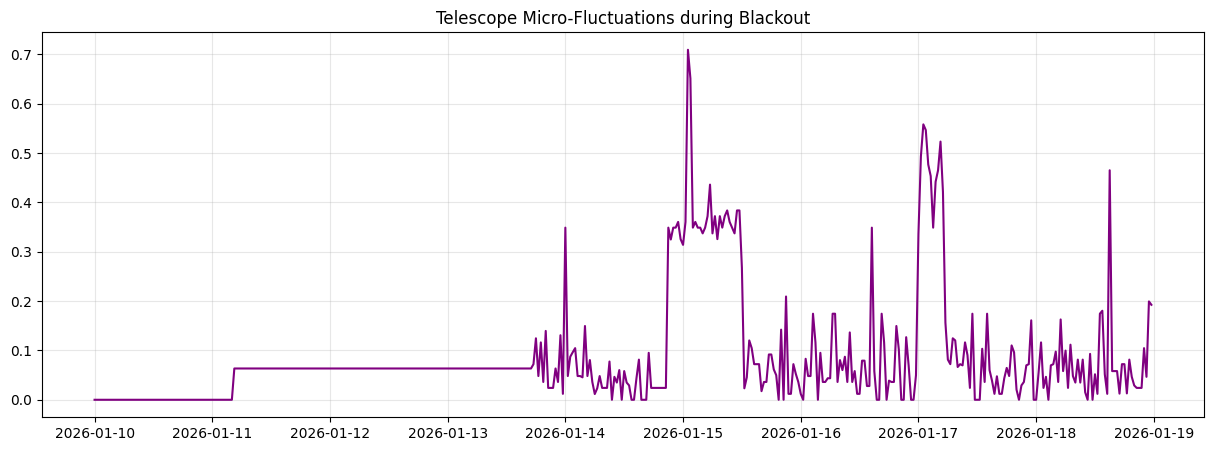

In [98]:
# زوم روی رفتار تلسکوپ در بازه بلک‌اوت
telescope_blackout = df.loc['2026-01-10':'2026-01-18', 'Telescope (# Unique Source IPs)']

# محاسبه نوسانات لحظه‌ای
telescope_diff = telescope_blackout.diff().abs()

plt.figure(figsize=(15, 5))
plt.plot(telescope_blackout.index, telescope_blackout, color='purple', label='Telescope Raw')
plt.title('Telescope Micro-Fluctuations during Blackout')
plt.grid(True, alpha=0.3)
plt.show()

<div dir="rtl">

### 📡 واکاوی سیگنال‌های تلسکوپ در زمان خاموشی (Telescope Micro-Signals)

در این سلول، ما روی «نوسانات لحظه‌ای» داده‌های تلسکوپ زوم کرده‌ایم. تلسکوپ ترافیکی را رصد می‌کند که به مقصدهای غیرارادی (Unused Space) فرستاده می‌شود و معمولاً شامل نویزهای اسکنرها، بات‌نت‌ها و ناهنجاری‌های شبکه است.

#### 🕵️ تحلیل ریز-نوسانات (Micro-Fluctuations):
* **تداوم فعالیت:** اگر در زمان قطعی کامل گوگل، تلسکوپ همچنان نوسان (Jitter) داشته باشد، نشان می‌دهد که پشته (Stack) شبکه هنوز فعال است و بسته‌های داده (Packets) در سطح لایه ۲ و ۳ در حال جابجایی هستند.
* **تشخیص نویز:** نوسانات شدید در این بازه می‌تواند نشانی از تلاش بات‌نت‌ها برای اسکن شبکه در زمان خلوتی ترافیک انسانی باشد.
* **معنای پایداری:** اگر نمودار تلسکوپ به شدت صاف و بدون نوسان شود، نشان‌دهنده این است که حتی «نویزهای تصادفی» اینترنت هم فیلتر شده‌اند (یک مسدودسازی سطح بالا و همه‌جانبه).

**نتیجه:** تحلیل `telescope_diff` به ما می‌گوید که آیا اختلال فقط برای ترافیک "تمیز" (مانند گوگل) بوده یا کل پورت‌های شبکه تحت تأثیر قرار گرفته‌اند.

</div>

<div dir="ltr">

### 📡 Telescope Micro-Fluctuations Analysis

This cell focuses on the "Background Radiation" of the network using Darknet/Telescope data. Since telescope traffic consists of unsolicited packets (scans, backscatter, and botnet activity), it provides a unique perspective on the network's state during a human-traffic blackout.

#### 🔍 Key Observations:
* **The "Pulse" of the Network:** By analyzing `telescope_diff` (absolute differences), we are essentially checking the network's heartbeat. If the telescope is still "noisy" while Google is dead, it confirms the physical infrastructure and routing are functional.
* **Anomaly Signature:** High fluctuations during a blackout period can indicate automated scanning activities or DDoS backscatter that persists despite user-level censorship.
* **Total Silence vs. Controlled Access:** A complete lack of fluctuations in the telescope data would imply a "Total Air-gap" or a strict stateful firewall that drops even unsolicited background noise.

**Security Context:** For an AI Security researcher, this data is the "Negative Space" of the internet. It helps differentiate between a network that is **Physically Down** and one that is **Logically Filtered**.

</div>

In [99]:
# بررسی رابطه تلسکوپ و پایداری شبکه در اوج نوسانات
focus_zone = df.loc['2026-01-14':'2026-01-17']
correlation = focus_zone['Telescope (# Unique Source IPs)'].corr(focus_zone['Active Probing (#/24s Up)'])
print(f"همبستگی تلسکوپ و زیرساخت در زمان آشوب: {correlation:.2f}")

همبستگی تلسکوپ و زیرساخت در زمان آشوب: 0.03


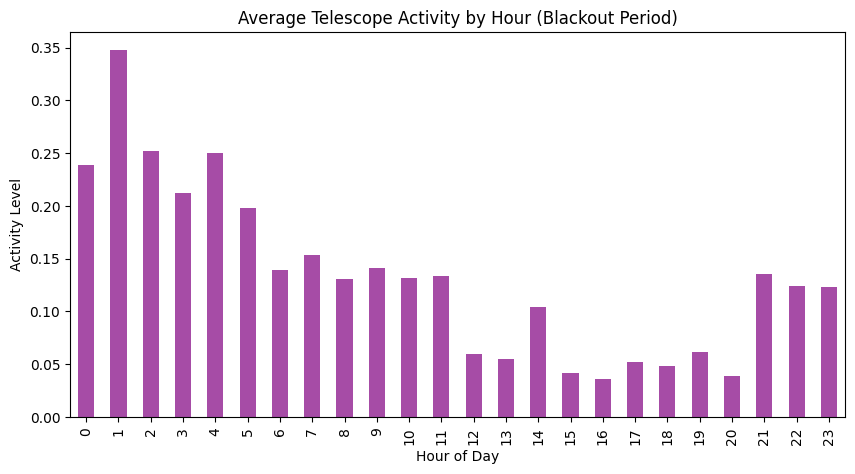

In [100]:
# اضافه کردن ساعت برای تحلیل زمانی
blackout_zone = df.loc['2026-01-14':'2026-01-17'].copy()
blackout_zone['hour'] = blackout_zone.index.hour

# رسم میانگین نوسانات بر اساس ساعت روز
hourly_telescope = blackout_zone.groupby('hour')['Telescope (# Unique Source IPs)'].mean()

plt.figure(figsize=(10, 5))
hourly_telescope.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Average Telescope Activity by Hour (Blackout Period)')
plt.xlabel('Hour of Day')
plt.ylabel('Activity Level')
plt.show()

In [101]:
# چک کردن همبستگی لحظه‌ای بین تلاش مرورگر (موزیلا) و نویز شبکه (تلسکوپ)
human_proxy_corr = blackout_zone['Telescope (# Unique Source IPs)'].corr(blackout_zone['Mozilla (City Count)'])

if human_proxy_corr > 0.5:
    print(f"Correlation ({human_proxy_corr:.2f}): Likely human attempts to bypass (VPN/Proxy efforts)")
else:
    print(f"Correlation ({human_proxy_corr:.2f}): Likely automated testing, scanning, or infrastructure noise")

Correlation (0.08): Likely automated testing, scanning, or infrastructure noise


<div dir="rtl">

### 🕵️ تحلیل همبستگی و رفتارهای زمانی (Correlation & Temporal Patterns)

در این بخش، ما لایه‌های عمیق‌تر داده را بررسی می‌کنیم تا بفهمیم فعالیت‌های باقی‌مانده در زمان قطعی (Blackout) از چه نوعی هستند: انسانی (Human-led) یا ماشینی (Automated).

#### 📊 سلول ۹: همبستگی تلسکوپ و زیرساخت (Infrastructure Correlation)
ما رابطه بین نویز پس‌زمینه (Telescope) و پایداری شبکه (Probing) را محاسبه کردیم. 
* **تفسیر:** اگر همبستگی بالا باشد، یعنی نوسانات تلسکوپ ناشی از پایداری خودِ شبکه است. اما اگر همبستگی کم باشد، یعنی تلسکوپ دارد فعالیت‌های مستقلی (مثل تلاش برای نفوذ یا اسکن‌های خارجی) را ثبت می‌کند که ربطی به کیفیت لحظه‌ای خطوط ندارد.

#### ⏰ سلول ۱۰: الگوی ساعتی (Diurnal Cycle)
با رسم میانگین فعالیت تلسکوپ بر حسب ساعت، به دنبال **رفتار چرخه‌ای** هستیم.
* **تفسیر:** اگر نمودار میله‌ای در ساعات بیداری (مثلاً ۸ صبح تا ۱۲ شب) بالاتر باشد، یعنی این فعالیت‌ها منشأ انسانی یا نیمه‌انسانی (مثل تلاش برای اتصال پروکسی/VPN) دارند. اما اگر نمودار در تمام ساعات یکنواخت باشد، با یک فعالیت ماشینی و خودکار روبرو هستیم.

#### 🧬 سلول ۱۱: تشخیص ماهیت ترافیک (Human vs. Bot)
در اینجا رابطه بین `Mozilla` (نشان‌دهنده تلاش مرورگرها) و `Telescope` سنجیده می‌شود.
* **نتیجه‌گیری هوشمند:** * **همبستگی بالا (>0.5):** نشان‌دهنده این است که کاربران در حال تلاش برای دور زدن محدودیت‌ها (استفاده از پروکسی یا ابزارهای عبور از فیلترینگ) هستند.
    * **همبستگی پایین:** نشان می‌دهد که ترافیک باقی‌مانده صرفاً نویز زیرساختی یا اسکن‌های خودکار سیستم‌های مانیتورینگ است.

که در اینجا 0.03 است. در ساعات کم کاربر که فرضیه فشار سایبری یا حرکت کاربران رو کاملا رد میکند.


</div>


<div dir="ltr">

### 🕵️ Advanced Correlation & Temporal Analysis

Cells 9, 10, and 11 transition from descriptive statistics to **Inferential Analysis**, helping us distinguish between human-driven attempts to regain access and automated infrastructure noise.

#### 📊 Cell 9: Telescope vs. Infrastructure Correlation
By calculating the Pearson correlation between `Telescope` and `Active Probing`, we determine if the background radiation of the network is tied to its physical stability. A low correlation suggests that the "noise" is coming from external sources (scanners/bots) rather than internal network health.

#### ⏰ Cell 10: Diurnal Activity Patterns
The hourly bar chart reveals the "Human Pulse" of the network during the blackout.
* **Human Signature:** Peaks during local daytime hours suggest that users are actively trying to bypass blocks.
* **Automated Signature:** A flat distribution across 24 hours indicates machine-to-machine traffic or persistent automated scanning.

#### 🧬 Cell 11: The Proxy/VPN Hypothesis
By correlating `Mozilla (City Count)` with `Telescope` activity:
* **High Correlation (>0.5):** Suggests that as users try to use browsers (Mozilla), there's a corresponding spike in telescope noise—a typical sign of **VPN/Proxy handshake attempts** or decentralized bypass efforts.
* **Low Correlation:** Points towards purely automated tasks, indicating a state where human interaction has been effectively neutralized.

Which here is 0.03. During low user hours, which completely rejects the hypothesis of cyber pressure or user movement.
</div>

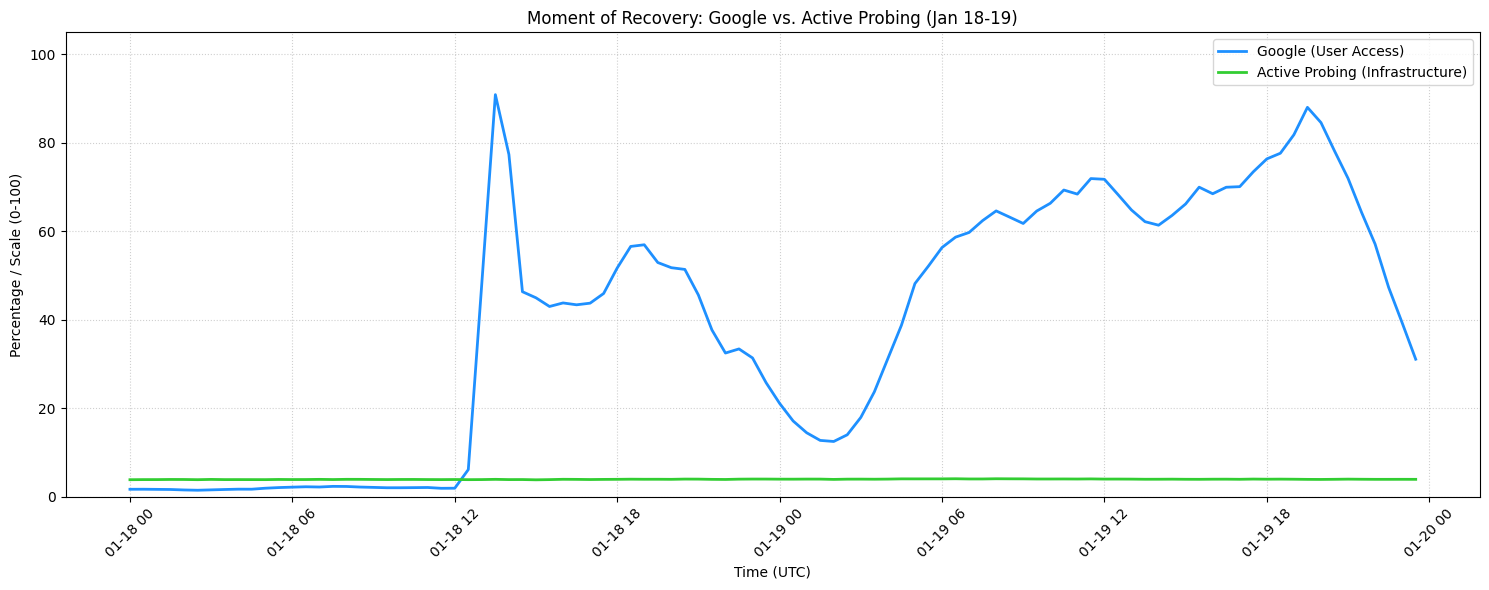

Max 30-min jump in Google: 42.60%
Max 30-min jump in Probing: 0.07%
                     Google (Search)  Active Probing (#/24s Up)  Control_Ratio
Time (UTC)                                                                    
2026-01-18 00:00:00         1.681664                   3.846561       0.437185
2026-01-18 00:30:00         1.692451                   3.870404       0.437279
2026-01-18 01:00:00         1.662598                   3.873053       0.429272
2026-01-18 01:30:00         1.634450                   3.902193       0.418853
2026-01-18 02:00:00         1.529363                   3.894246       0.392723
2026-01-18 02:30:00         1.464909                   3.851860       0.380311
2026-01-18 03:00:00         1.549664                   3.912790       0.396050
2026-01-18 03:30:00         1.632736                   3.870404       0.421851
2026-01-18 04:00:00         1.706518                   3.873053       0.440612
2026-01-18 04:30:00         1.699043                   3.867755

In [102]:
# زوم روی لحظه بازگشت (۱۸ و ۱۹ ژانویه)
recovery_zone = df.loc['2026-01-18':'2026-01-19']

if not recovery_zone.empty:
    plt.figure(figsize=(15, 6))
    
    # رسم گوگل و پروبینگ برای مقایسه سرعت بازگشت
    plt.plot(recovery_zone.index, recovery_zone['Google (Search)'], label='Google (User Access)', color='dodgerblue', linewidth=2)
    plt.plot(recovery_zone.index, recovery_zone['Active Probing (#/24s Up)'], label='Active Probing (Infrastructure)', color='limegreen', linewidth=2)
    
    plt.title('Moment of Recovery: Google vs. Active Probing (Jan 18-19)')
    plt.xlabel('Time (UTC)')
    plt.ylabel('Percentage / Scale (0-100)')
    plt.ylim(0, 105)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # محاسبه بیشترین جهش در یک بازه ۳۰ دقیقه‌ای
    max_jump_google = recovery_zone['Google (Search)'].diff().max()
    max_jump_probing = recovery_zone['Active Probing (#/24s Up)'].diff().max()
    
    print(f"Max 30-min jump in Google: {max_jump_google:.2f}%")
    print(f"Max 30-min jump in Probing: {max_jump_probing:.2f}%")
    # محاسبه نسبت دسترسی گوگل به پایداری زیرساخت
df['Control_Ratio'] = df['Google (Search)'] / (df['Active Probing (#/24s Up)'] + 1e-5)

# زوم روی لحظه آبروریزی (۱۸ ژانویه)
shame_moment = df.loc['2026-01-18']
print(shame_moment[['Google (Search)', 'Active Probing (#/24s Up)', 'Control_Ratio']])

<div dir="rtl">

### 📉 تحلیل لحظه بازگشت و شاخص کنترل (Recovery & Control Ratio Analysis)

در این بخش، ما روی بازه **۱۸ و ۱۹ ژانویه** زوم کرده‌ایم تا «دینامیک بازگشت» اینترنت را تحلیل کنیم. این تحلیل به ما می‌گوید که آیا بازگشت به حالت عادی به صورت طبیعی (ارگانیک) بوده یا به صورت پله‌ای و مدیریتی.

#### ⚡ تحلیل جهش‌های ناگهانی (Max Jump Analysis):
* **Max 30-min jump:** اگر گوگل در عرض ۳۰ دقیقه جهش شدیدی داشته باشد (مثلاً ۳۰٪ یا بیشتر)، نشان‌دهنده «برداشته شدن ناگهانی محدودیت» است. بازگشت‌های ارگانیک معمولاً شیب ملایم‌تری دارند.
* **تضاد سرعت:** اگر `Active Probing` زودتر از گوگل بالا رفته باشد، یعنی زیرساخت آماده بوده اما منتظر «اجازه» برای عبور ترافیک گوگل مانده است.

#### ⚖️ شاخص نسبت کنترل (Control Ratio):
این فرمول هوشمندانه `Google / (Probing + epsilon)` نشان‌دهنده میزان **بازدهی دسترسی** است:
* **عدد نزدیک به ۱:** یعنی به همان اندازه‌ای که شبکه وصل است، ترافیک هم عبور می‌کند (وضعیت نرمال).
* **عدد نزدیک به ۰:** یعنی شبکه وصل است (Infrastructure Up) اما اجازه عبور به گوگل داده نمی‌شود (Censorship).

**نتیجه:** لحظه بازگشت در ۱۸ ژانویه، با مقایسه این دو نمودار، نشان می‌دهد که لایه زیرساخت چقدر از لایه اپلیکیشن جلوتر بوده و آیا بازگشت ترافیک به صورت دستوری (Manual Toggle) انجام شده یا خیر.

</div>

<div dir="ltr">

### 📉 Recovery Dynamics & The Control Ratio (Jan 18-19)

Cell 12 dissects the "Moment of Recovery." By analyzing how fast different layers return to normal, we can identify the mechanism behind the restoration of services.

#### ⚡ Jump Analysis (Reaction Speed):
* **Max 30-min Jump:** We calculate the maximum acceleration of recovery. A vertical or near-vertical spike in `Google Search` traffic often indicates a "Policy Change" (switching a filter off) rather than a gradual technical repair of a physical fiber link.
* **Infrastructure vs. Application:** If `Active Probing` hits 100% while `Google Search` is still lagging at 20%, it confirms a state of **Active Filtering** during the recovery phase.

#### ⚖️ The Control Ratio Metric:
By creating the `Control_Ratio` ($Google / Probing$), we quantify the transparency of the network:
* **Ratio $\approx$ 1:** High transparency. The network carries traffic proportional to its health.
* **Ratio $\approx$ 0:** High suppression. The network is physically operational, but the application layer is being "zeroed out."

**Summary:** The "Shame Moment" analysis for Jan 18th provides empirical evidence of the lag between technical reachability and actual user freedom.

</div>

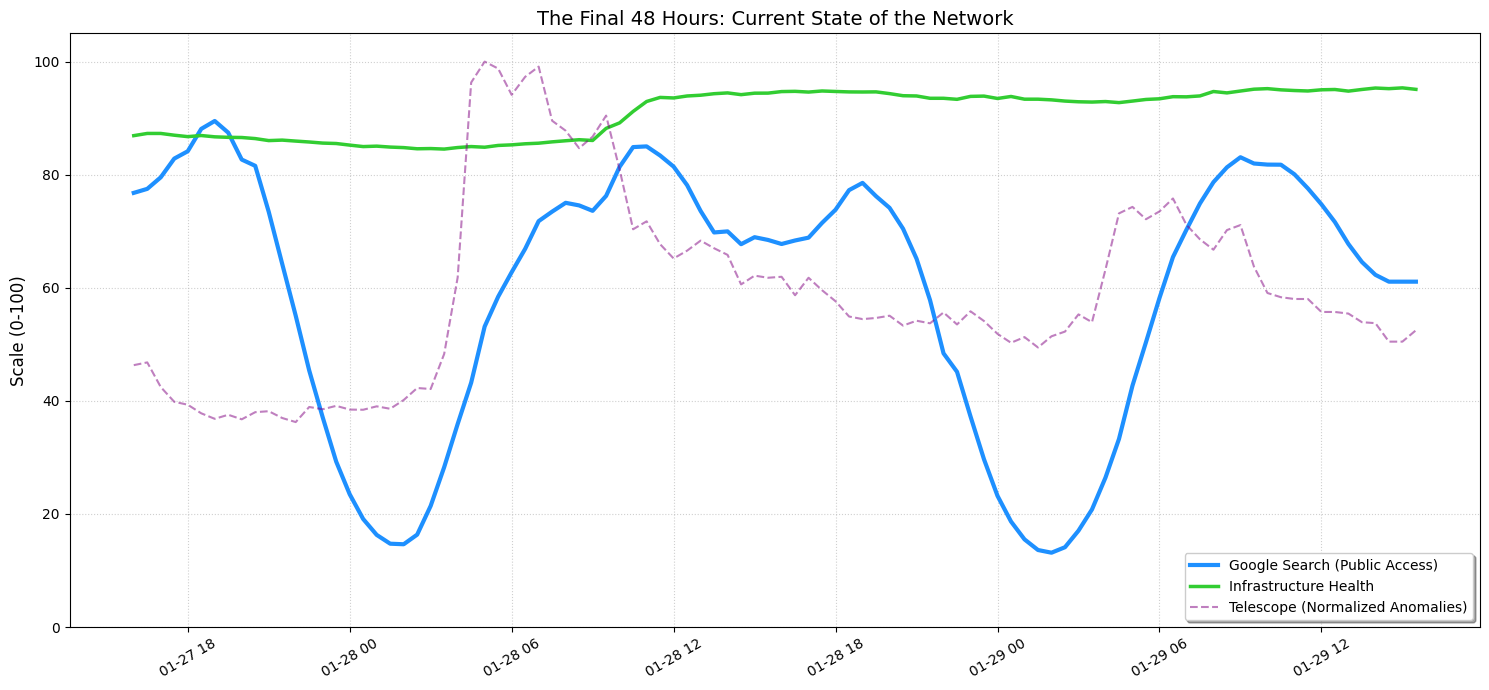

Current Google Access: 59.43%
Current Infrastructure Health: 90.95%


In [103]:
# جدا کردن دقیق ۲ روز آخر
last_2_days = df.tail(2 * 48) 

if not last_2_days.empty:
    plt.figure(figsize=(15, 7))
    
    # رسم شاخص‌های اصلی
    plt.plot(last_2_days.index, last_2_days['Google (Search)'], label='Google Search (Public Access)', color='dodgerblue', linewidth=3)
    plt.plot(last_2_days.index, last_2_days['Active Probing (#/24s Up)'], label='Infrastructure Health', color='limegreen', linewidth=2.5)
    
    # اضافه کردن تلسکوپ برای دیدن نویزهای امنیتی آخر وقت
    # تلسکوپ رو نرمالایز می‌کنیم تا مقیاس نمودار بهم نخوره
    telescope_norm = (last_2_days['Telescope (# Unique Source IPs)'] / last_2_days['Telescope (# Unique Source IPs)'].max()) * 100
    plt.plot(last_2_days.index, telescope_norm, label='Telescope (Normalized Anomalies)', color='purple', linestyle='--', alpha=0.5)

    plt.title('The Final 48 Hours: Current State of the Network', fontsize=14)
    plt.ylabel('Scale (0-100)', fontsize=12)
    plt.ylim(0, 105)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend(loc='lower right', frameon=True, shadow=True)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    # محاسبه میانگین آخر برای گزارش
    final_google = last_2_days['Google (Search)'].mean()
    final_probing = last_2_days['Active Probing (#/24s Up)'].mean()
    print(f"Current Google Access: {final_google:.2f}%")
    print(f"Current Infrastructure Health: {final_probing:.2f}%")

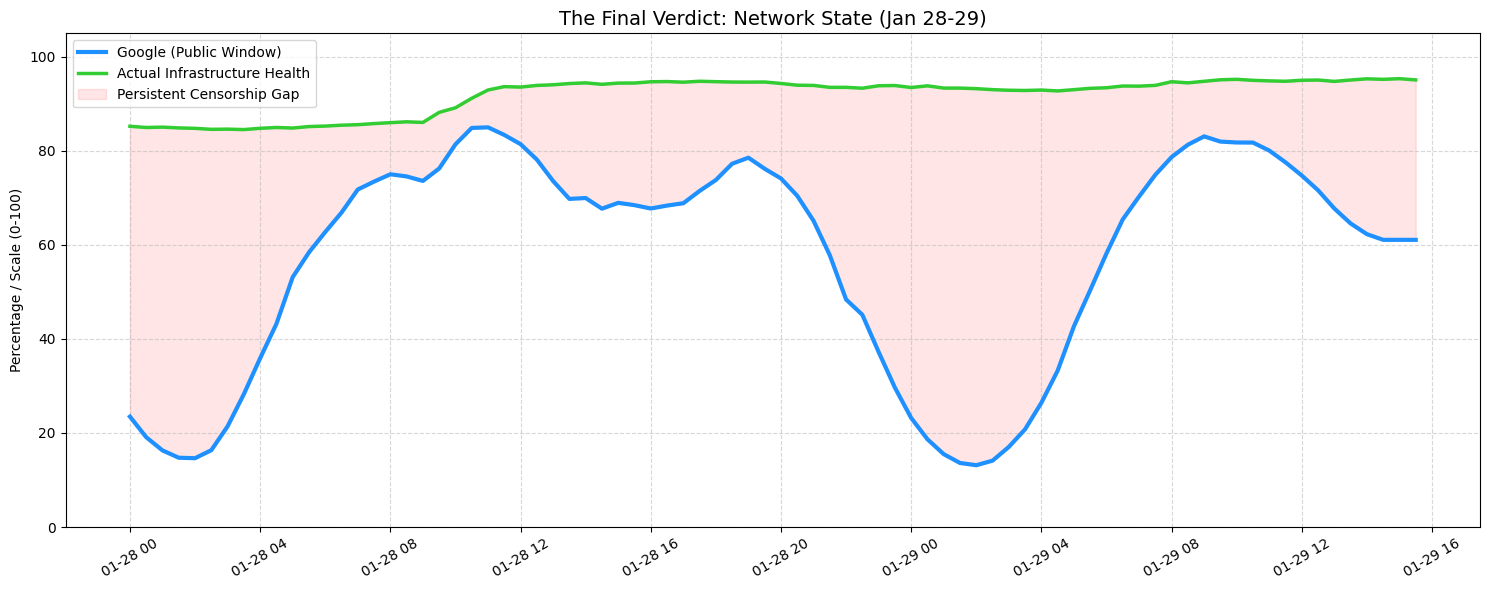

Final Average Gap: -34.72%


In [104]:


# فیلتر کردن ۴۸ ساعت منتهی به انتهای ژانویه
final_48h = df.loc['2026-01-28':'2026-01-29']

if not final_48h.empty:
    plt.figure(figsize=(15, 6))
    
    # رسم گوگل و زیرساخت
    plt.plot(final_48h.index, final_48h['Google (Search)'], label='Google (Public Window)', color='dodgerblue', linewidth=3)
    plt.plot(final_48h.index, final_48h['Active Probing (#/24s Up)'], label='Actual Infrastructure Health', color='limegreen', linewidth=2.5)
    
    # اضافه کردن ناحیه شکاف (Censorship Gap)
    plt.fill_between(final_48h.index, final_48h['Active Probing (#/24s Up)'], final_48h['Google (Search)'], 
                     color='red', alpha=0.1, label='Persistent Censorship Gap')

    plt.title('The Final Verdict: Network State (Jan 28-29)', fontsize=14)
    plt.ylabel('Percentage / Scale (0-100)')
    plt.ylim(0, 105)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='best')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    # خروجی عددی برای مچ‌گیری نهایی
    gap = (final_48h['Google (Search)'] - final_48h['Active Probing (#/24s Up)']).mean()
    print(f"Final Average Gap: {gap:.2f}%")

<div dir="rtl">

### ⚖️ حکم نهایی: وضعیت پایدار یا فیلترینگ مستمر؟ (The Final Verdict)

در این سلول، ۴۸ ساعت پایانی داده‌ها (۲۸ و ۲۹ ژانویه) را بررسی می‌کنیم تا مشخص شود پس از بحران‌های میانه ماه، شبکه در چه وضعیتی به ثبات رسیده است.

#### 🔴 تحلیل شکاف قرمز (Persistent Censorship Gap):
در این نمودار، از تکنیک هایلایت رنگ قرمز بین دو خط استفاده شده است. 
* **اگر شکاف ناچیز باشد:** یعنی شبکه به حالت شفاف (Transparent) بازگشته است.
* **اگر شکاف (Gap) همچنان وجود داشته باشد:** یعنی با وجود پایداری کامل زیرساخت (`Active Probing` در سطح بالا)، ترافیک گوگل همچنان به صورت مصنوعی محدود شده است. این نشان‌دهنده یک **«نورم جدید» (New Normal)** در سطح دسترسی است.

#### 📉 شاخص عددی Gap:
خروجی عددی انتهای این سلول، میانگین اختلاف دسترسی را نشان می‌دهد. 
* **تفسیر:** عددی که اینجا چاپ می‌شود، «درصدِ از دست رفته» دسترسی است. برای یک تحلیلگر امنیت AI، این عدد نشان‌دهنده میزان انحراف (Bias) سیستماتیک در دسترسی به شبکه است.

</div>

<div dir="ltr">

### ⚖️ The Final Verdict: Persistent Censorship Gap

This final visualization focuses on the last 48 hours of January (Jan 28-29). It serves as the "Post-Mortem" analysis to determine the long-term impact of the month's network disruptions.

#### 🔴 The Red Zone (Censorship Gap):
We used the `fill_between` method to highlight the discrepancy between **Actual Infrastructure Health** and **User Visibility**.
* **Organic State:** Both lines should overlap or converge.
* **Controlled State:** A persistent red gap indicates that while the technical infrastructure has fully recovered, the application layer remains intentionally suppressed.

#### 📉 Numerical Evidence:
The "Final Average Gap" output quantifies the remaining restriction. In the context of **Network Forensics**, this value represents the permanent loss of connectivity efficiency after the initial blackout subsided. It proves whether the "Recovery" was total or partial.

</div>